Model orthogonalization with LDM variants (heavily based on Vojta's naive code "toymodels.ipynb"). This is an interactive jupyter notebook, that will explore different choices for the construction of the principal components. For now we will only play with the following scenarios:


* 1 good model 1 bad model
* 3 good models 10 bad models
* 1 pefect model, 3 good models, 10 bad models



This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants: Data preparation
    └── PCA - Analysis

        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [1]:
# pip install corner

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner 



#Some colors that Pablo likes:
colors = [
    "#ff7f0e",

    "#1f77b4",

    "#2ca02c",
    "#d62728",
    
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
] 

markers = [
    "o",  # Circle
    "^",  # Triangle up
    "s",  # Square
    "P",  # Plus (filled)
    "*",  # Star
    "X",  # X (filled)
    "D",  # Diamond
    "H",  # Hexagon
]






def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)


    return A*params[0] + params[1] * A ** (2/3) + params[2] * A ** (1/3)  +  params[3] * I ** 2*A + \
                + params[4] * (I ** 2) * A ** (2/3) + params[5] * (I ** 4)*A + params[6]*((z**2)/((A)**(1/3))) 





### Global variables####

# SkO values selected for the truth

truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

PerfectM_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 
GoodM_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1
BadM_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]

# NL_1 
TerribleM_params = [-15.972, 18.4, 9, 0, 0, 0, 0.57]



### Next cell are things you (the user) might want to change

In [2]:

#Noises
##########################

#Turn off term (to make colinear examples). Turn it to 1 or 0

switch=0
# switch=1

#Noise terms to be added to the parameters
params_noise_term_p=0.000*switch
params_noise_term_g=0.002*switch
params_noise_term_b=0.002*switch
params_noise_term_t=0.002*switch

# params_noise_term_p=0.000
# params_noise_term_g=0.00
# params_noise_term_b=0.00
# params_noise_term_t=0.00


overall_output_noise=1*switch   # Noise added to each observation coming from models

# overall_output_noise=0.000   # Noise added to each observation coming from models

overall_data_noise= 1*switch  #Noise added to the "true" generated data itself




#Data separation (training, testing, validation) set ups
##########################

#Number used for when dividing training and testing randomly uniformly (interpolating)
TestingFraction=0.34

#Number used for when dividing training and testing by how close they are to the stable nuclei
distance=2

#Coordinates to truncate so the LDM evaluations are not done below these isotopes
minimumZ=8
minimumN=8



#Centering set up
##########################
centering_data=True




#Scenario set up
##########################

n_perfect =1
n_good = 3
n_bad = 5
n_terrible=10

n_classes=[n_perfect,n_good,n_bad,n_terrible]
#Re-labeling terrible by "bad" so we are not too insensitive to the poor model
# n_Labels=["Perfect M.", "Good M.", "Inter. M.","Bad M."]
n_Labels=["Perfect", "Good", "Inter.","Bad"]



#Isotope chain for 1-D plotting selection
##########################
Selected_element=50
Selected_element_name="Sn"



#Computing constrained MCMC? (takes ~ + 5 minutes extra time)
##########################
computing_MCMC=True

In [3]:
#Some functions for plotting capabilities

def plot_bars(values, labels, title="Bar Plot", color='blue'):
    """
    Create a bar plot based on the provided values and labels.

    Parameters:
    - values (list): A list of numerical values for the bars.
    - labels (list): A list of labels for each bar.
    - title (str): The title for the bar plot. Default is "Bar Plot".
    - color (str): Color for the bars. Default is 'blue'.
    """
    
    if len(values) != len(labels):
        raise ValueError("Length of values and labels should be the same.")
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Vt Coordinates')
    plt.xticks(labels,fontsize=10,rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


def Plotter2D_single(data):
    xvals,yvals,zvals = data
    #A plotter to see principal components in 2D
    plt.rc("xtick", labelsize=25)
    plt.rc("ytick", labelsize=25)
    
    fig, ax = plt.subplots(figsize=(12, 8), dpi=200)

    # Create scatter plot
    sc = ax.scatter(xvals, yvals, c=zvals, s=25, cmap='plasma',marker='s')
    # plt.colorbar(sc, label='Z-Value')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Z-Value', fontsize=25) 
    cbar.ax.tick_params(labelsize=20) 
    plt.xlabel('Neutrons',fontsize=25)
    plt.ylabel('Protons',fontsize=25)

    ax.grid(True)
    # ax.axis('equal')

    plt.show()

def Plotter3D_single(data,elev=30,azim=-60):
    xvals,yvals,zvals = data
    #A plotter to see principal components in 3D
    plt.rc("xtick", labelsize=15)
    plt.rc("ytick", labelsize=15)

    z_min = zvals.min()
    z_max = zvals.max()
    z_normalized = (zvals - z_min) / (z_max - z_min)

    # Create figure for 3D plot
    fig = plt.figure(figsize=(8, 6), dpi=200)
    ax = fig.add_subplot(111, projection='3d')



    # Define the size of the bars
    dx = dy = 1.5  # Width of the bars in the x and y direction
    dz = z_normalized        # Height of the bars (z values)

    # Create 3D bar plot
    ax.bar3d(xvals, yvals, np.zeros_like(zvals), dx, dy, dz, color=plt.cm.plasma(z_normalized))

    ax.view_init(elev=elev, azim=azim) 

    # Setting labels and title
    ax.set_xlabel('Neutrons')
    ax.set_ylabel('Protons')
    ax.set_zlabel('Scaled Z')


    plt.show()    



def Plotter2D(ax,xvals,yvals,zvals):
    #A plotter to see principal components in 2D, part of the big plotter



    # Create scatter plot
    sc = ax.scatter(xvals, yvals, c=zvals, s=25, cmap='plasma',marker='s')
    # plt.colorbar(sc, label='Z-Value')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Z-Value', fontsize=25) 
    cbar.ax.tick_params(labelsize=20) 




    plt.xlabel('Neutrons',fontsize=25)
    plt.ylabel('Protons',fontsize=25)

    ax.grid(True)
    ax.axis('equal')

    # plt.show()

def Plotter3D(ax,xvals,yvals,zvals,elev=30,azim=-60):
    #A plotter to see principal components in 3D, part of the big plotter


    z_min = zvals.min()
    z_max = zvals.max()
    z_normalized = (zvals - z_min) / (z_max - z_min)

    # Create figure for 3D plot
    # fig = plt.figure(figsize=(8, 6), dpi=200)
    # ax = fig.add_subplot(111, projection='3d')



    # Define the size of the bars
    dx = dy = 1.5  # Width of the bars in the x and y direction
    dz = z_normalized        # Height of the bars (z values)

    # Create 3D bar plot
    ax.bar3d(xvals, yvals, np.zeros_like(zvals), dx, dy, dz, color=plt.cm.plasma(z_normalized))

    ax.view_init(elev=elev, azim=azim) 

    # Setting labels and title
    ax.set_xlabel('Neutrons')
    ax.set_ylabel('Protons')
    ax.set_zlabel('Scaled Z')


    # plt.show()    



def PlotMultiple(data_sets,angles_sheet=None):
    # Determine the number of rows needed for the plots
    n_rows = len(data_sets)
    # Each data_sets element should look like [x,y,z]

    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 8 * n_rows), dpi=200)

    for i, (xvals, yvals, zvals) in enumerate(data_sets):
        # 2D plot
        ax_2d = fig.add_subplot(n_rows, 2, 2 * i + 1)
        Plotter2D(ax_2d, xvals, yvals, zvals)

        # 3D plot
        ax_3d = fig.add_subplot(n_rows, 2, 2 * i + 2, projection='3d')
        if angles_sheet == None:
            Plotter3D(ax_3d, xvals, yvals, zvals)
        else:
            Plotter3D(ax_3d, xvals, yvals, zvals,elev=angles_sheet[0],azim=angles_sheet[1])

    plt.tight_layout()
    plt.show()



In [4]:
def separate_points_random(list1,random_chance):
    """
    Separates points in list1 into two groups randomly

    """
    train = []
    test = []

    train_list_coordinates=[]
    test_list_coordinates=[]


    for i in range(len(list1)):
        point1=list1[i]
        val=np.random.rand()
        if val<=random_chance:
            train.append(point1)
            train_list_coordinates.append(i)
        else:
            test.append(point1)
            test_list_coordinates.append(i)

    return np.array(train), np.array(test), np.array(train_list_coordinates), np.array(test_list_coordinates)


In [5]:
def separate_points_distance(list1, list2, distance):
    """
    Separates points in list1 into two groups based on their proximity to any point in list2.

    :param list1: List of (x, y) tuples.
    :param list2: List of (x, y) tuples.
    :param distance: The threshold distance to determine proximity.
    :return: Two lists - close_points and distant_points.
    """
    train = []
    test = []

    train_list_coordinates=[]
    test_list_coordinates=[]

    for i in range(len(list1)):
        point1=list1[i]
        close = False
        for point2 in list2:
            if np.linalg.norm(np.array(point1) - np.array(point2)) <= distance:
                close = True
                break
        if close:
            train.append(point1)
            train_list_coordinates.append(i)
        else:
            test.append(point1)
            test_list_coordinates.append(i)

    return np.array(train), np.array(test), np.array(train_list_coordinates), np.array(test_list_coordinates)


In [6]:
def separate_points_distance_allSets(list1, list2, distance1, distance2):
    """
    Separates points in list1 into three groups based on their proximity to any point in list2.

    :param list1: List of (x, y) tuples.
    :param list2: List of (x, y) tuples.
    :param distance: The threshold distance to determine proximity.
    :return: Two lists - close_points and distant_points.
    """
    train = []
    validation=[]
    test = []

    train_list_coordinates=[]
    validation_list_coordinates=[]
    test_list_coordinates=[]

    for i in range(len(list1)):
        point1=list1[i]
        close = False
        for point2 in list2:
            if np.linalg.norm(np.array(point1) - np.array(point2)) <= distance1:
                close = True
                break
        if close:
            train.append(point1)
            train_list_coordinates.append(i)
        else:
            close2=False
            for point2 in list2:
                if np.linalg.norm(np.array(point1) - np.array(point2)) <= distance2:
                    close2 = True
                    break
            if close2==True:
                validation.append(point1)
                validation_list_coordinates.append(i)
            else:
                test.append(point1)
                test_list_coordinates.append(i)                

    return np.array(train),np.array(validation), np.array(test), np.array(train_list_coordinates),  np.array(validation_list_coordinates),np.array(test_list_coordinates)


In [7]:
stable_coordinates_full=np.loadtxt("Stable-Isotopes.txt")

In [8]:
stable_coordinates=[]

for i in range(len(stable_coordinates_full)):
    if (stable_coordinates_full[i][0]>=minimumN) & (stable_coordinates_full[i][1]>=minimumZ) & (stable_coordinates_full[i][0]% 2 == 0) & (stable_coordinates_full[i][1]% 2 == 0) :
        stable_coordinates.append(stable_coordinates_full[i])

stable_coordinates=np.array(stable_coordinates)

In [9]:
# Full_set_2003=np.loadtxt("AME2003.txt")
# Full_set_2016=np.loadtxt("AME2016.txt")


# AME2003_even=[]


# for i in range(len(Full_set_2003)):
#     if (Full_set_2003[i][0]>=minimumN) & (Full_set_2003[i][1]>=minimumZ) & (Full_set_2003[i][0]% 2 == 0) & (Full_set_2003[i][1]% 2 == 0) :
#         AME2003_even.append([Full_set_2003[i][0],Full_set_2003[i][1]])

# AME2003_even=np.array(AME2003_even)


# AME2016_even=[]


# for i in range(len(Full_set_2016)):
#     if (Full_set_2016[i][0]>=minimumN) & (Full_set_2016[i][1]>=minimumZ) & (Full_set_2016[i][0]% 2 == 0) & (Full_set_2016[i][1]% 2 == 0) :
#         AME2016_even.append([Full_set_2016[i][0],Full_set_2016[i][1]])

# AME2016_even=np.array(AME2016_even)

In [10]:

Full_set_2020=np.loadtxt("AME2020.txt")
AME2020_even=[]


for i in range(len(Full_set_2020)):
    if (Full_set_2020[i][0]>=minimumN) & (Full_set_2020[i][1]>=minimumZ) & (Full_set_2020[i][0]% 2 == 0) & (Full_set_2020[i][1]% 2 == 0) :
        AME2020_even.append([Full_set_2020[i][0],Full_set_2020[i][1]])

AME2020_even=np.array(AME2020_even)

In [11]:
Full_set=np.copy(AME2020_even)

In [12]:
# #Separating randomly
# np.random.seed(142857)
# training_set, testing_set, train_coordinates, test_coordinates=separate_points_random(Full_set, TestingFraction)


In [13]:
distance1=2
distance2=3

training_set, validation_set, test_set,train_coordinates0, validation_coordinates0,test_coordinates0=separate_points_distance_allSets(AME2020_even, stable_coordinates, distance1,distance2)

In [14]:
train_coordinates=[]
for i in range(len(Full_set)):
    isotope2020=Full_set[i]
    for j in range(len(training_set)):
       train_isotope=training_set[j]
       if (isotope2020[0]==train_isotope[0]) & (isotope2020[1]==train_isotope[1]):
           train_coordinates.append(i)
           break
train_coordinates=np.array(train_coordinates)

In [15]:
validation_coordinates=[]
for i in range(len(Full_set)):
    isotope2020=Full_set[i]
    for j in range(len(validation_set)):
       validation_isotope=validation_set[j]
       if (isotope2020[0]==validation_isotope[0]) & (isotope2020[1]==validation_isotope[1]):
           validation_coordinates.append(i)
           break
validation_coordinates=np.array(validation_coordinates)

In [16]:
test_coordinates=[]
for i in range(len(Full_set)):
    isotope2020=Full_set[i]
    for j in range(len(test_set)):
       test_isotope=test_set[j]
       if (isotope2020[0]==test_isotope[0]) & (isotope2020[1]==test_isotope[1]):
           test_coordinates.append(i)
           break
test_coordinates=np.array(test_coordinates)

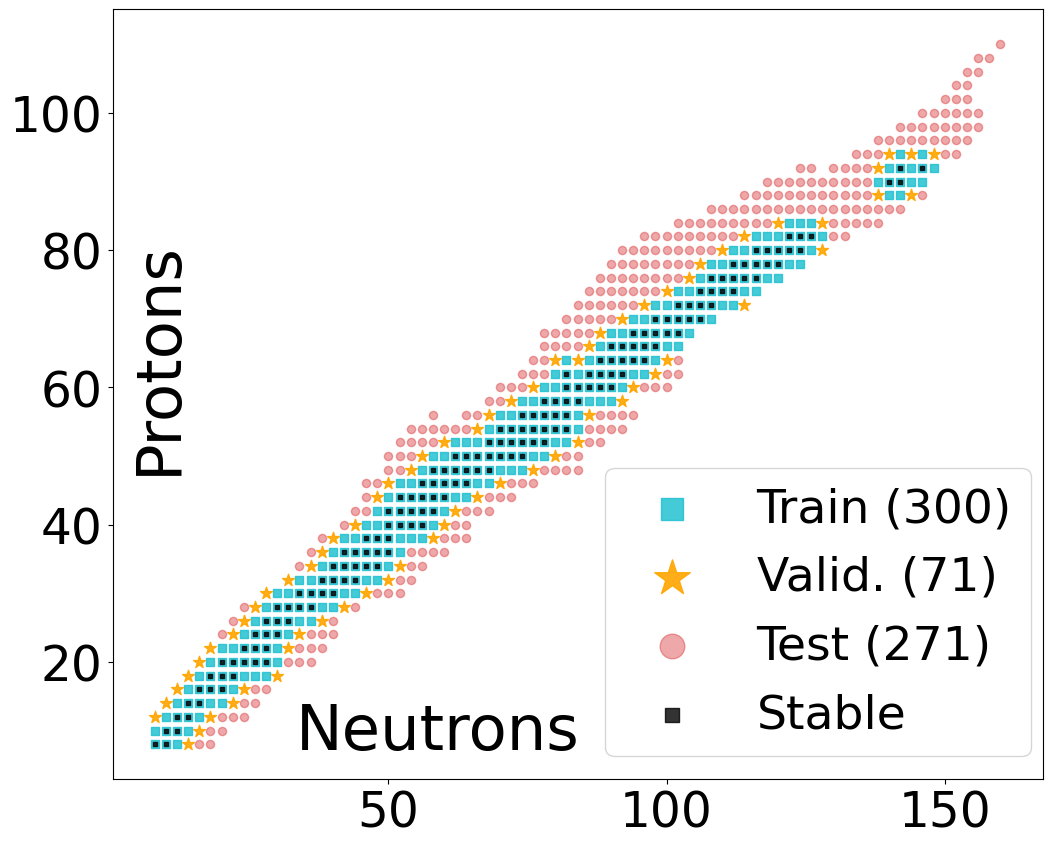

In [17]:
plt.rc("xtick", labelsize=35)
plt.rc("ytick", labelsize=35)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


color_trainig=colors[9]
color_validation='orange'
color_testing=colors[3]

marker_trainig='s'
marker_validation='*'
marker_testing='o'



size_trainig=30
size_validation=80
size_testing=35

alpha_trainig=0.8
alpha_validation=0.9
alpha_testing=0.4



ax.scatter(x = training_set.T[0], y = training_set.T[1], label = "Train ("+ str(len(training_set))+")", alpha = alpha_trainig,color=color_trainig,s=size_trainig,marker=marker_trainig)

ax.scatter(x = validation_set.T[0], y = validation_set.T[1], label = "Valid. (" + str(len(validation_set))+")", alpha = alpha_validation,color=color_validation,s=size_validation,marker=marker_validation)

ax.scatter(x = test_set.T[0], y = test_set.T[1], label = "Test (" + str(len(test_set))+")", alpha = alpha_testing,color=color_testing,s=size_testing,marker=marker_testing)


ax.scatter(x = stable_coordinates.T[0], y = stable_coordinates.T[1], label = "Stable", alpha = 0.8,color='black',s=11,marker="s")



plt.xlabel('')

plt.annotate('Neutrons', xy=(0.35, 0.1), xycoords='axes fraction',
             ha='center', va='top', fontsize=45) 
plt.ylabel('')

plt.annotate('Protons', xy=(0.05,0.7), xycoords='axes fraction',
             ha='center', va='top', fontsize=45,rotation =90) 


# plt.ylabel("Protons",fontsize=45)
plt.legend(fontsize=34,markerscale=3 ,loc =(0.53,0.03))
plt.show()

In [18]:
overall_output_noise

0

In [19]:


# masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) 

models_output = {}
models_output_train = {}
models_output_validation = {}
models_output_test = {}





# #Option 1: Constructing the data by just adding a random noise to the output of the models
# #Perfect Models Loop
# params = PerfectM_params
# for i in range(n_perfect):
#     models_output[str("PerfectModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_p


# #Good Models Loop
# params = GoodM_params
# for i in range(n_good):
#     models_output[str("GoodModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_g

# #Bad Models Loop
# params = BadM_params
# for i in range(n_bad):
#     models_output[str("IntermediateModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_b

# #Terrible Models Loop
# params = TerribleM_params
# for i in range(n_terrible):
#     models_output[str("BadModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_t




#Option 2: Constructing the data by adding a random noise to the parameters of the models, plus random noise to the output
#Perfect Models Loop
np.random.seed(142857)
params = PerfectM_params
for i in range(n_perfect):
    ran_params=params + np.random.normal(0,1,size=len(params))*params*params_noise_term_p
    models_output[str("PerfectModel_")+str(i)] = LDM_extended(ran_params,Full_set.T)+np.random.normal(0,1,size=len(Full_set)) * overall_output_noise



#Good Models Loop
np.random.seed(542857)
params = GoodM_params
for i in range(n_good):

    ran_params=params+ np.random.normal(0,1,size=len(params))*params*params_noise_term_g


    models_output[str("GoodModel_")+str(i)] = LDM_extended(ran_params
                                                           ,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise




#Bad Models Loop
np.random.seed(342857)
params = BadM_params
for i in range(n_bad):
    ran_params=params+ np.random.normal(0,1,size=len(params))*params*params_noise_term_b
    models_output[str("IntermediateModel_")+str(i)] = LDM_extended(ran_params,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise


    



#Terrible Models Loop
np.random.seed(442857)
params = TerribleM_params
for i in range(n_terrible):
    ran_params=params+ np.random.normal(0,1,size=len(params))*params*params_noise_term_t


    models_output[str("BadModel_")+str(i)] = LDM_extended(ran_params
                                                          ,Full_set.T)+ np.random.normal(0,1,size=len(Full_set)) * overall_output_noise
    


#This is done here to have a list of pure models, without the ground truth
key_list=list(models_output.keys())
np.random.seed(7*142857)
models_output['truth']=LDM_extended(truth_params,Full_set.T) + np.random.normal(0,1,size=len(Full_set))*overall_data_noise


models_output = pd.DataFrame(models_output)
models_output["N"] = Full_set.T[0]
models_output["Z"] = Full_set.T[1]
models_output["A"] = models_output["N"] + models_output["Z"]







In [20]:
#Separating outputs for the three regions
models_output_train = models_output.iloc[train_coordinates]

models_output_validation = models_output.iloc[validation_coordinates]

models_output_test = models_output.iloc[test_coordinates]

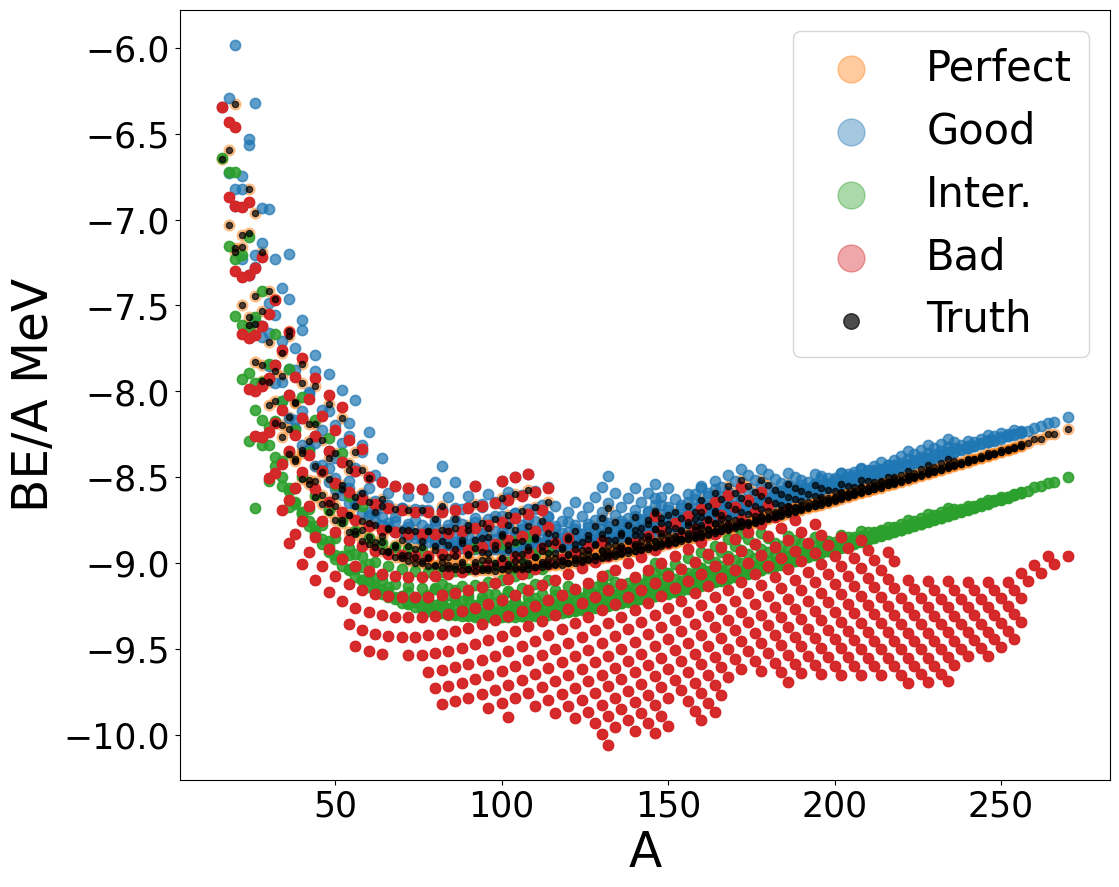

In [21]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.scatter(x = models_output["A"], y = models_output[key_list[model_index]]/models_output["A"], label = n_Labels[class_index], alpha = 0.4,color=colors[class_index],marker=markers[0],s=60)
        else:
            ax.scatter(x = models_output["A"], y = models_output[key_list[model_index]]/models_output["A"],  alpha = 0.3,color=colors[class_index],marker=markers[0],s=50)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = models_output["A"], y = models_output['truth']/models_output["A"], label = "Truth", alpha = 0.7,color='k',s=20)


plt.xlabel("A",fontsize=35)
plt.ylabel("BE/A MeV",fontsize=35)
plt.legend(fontsize=30,markerscale=2.5 )

plt.show()

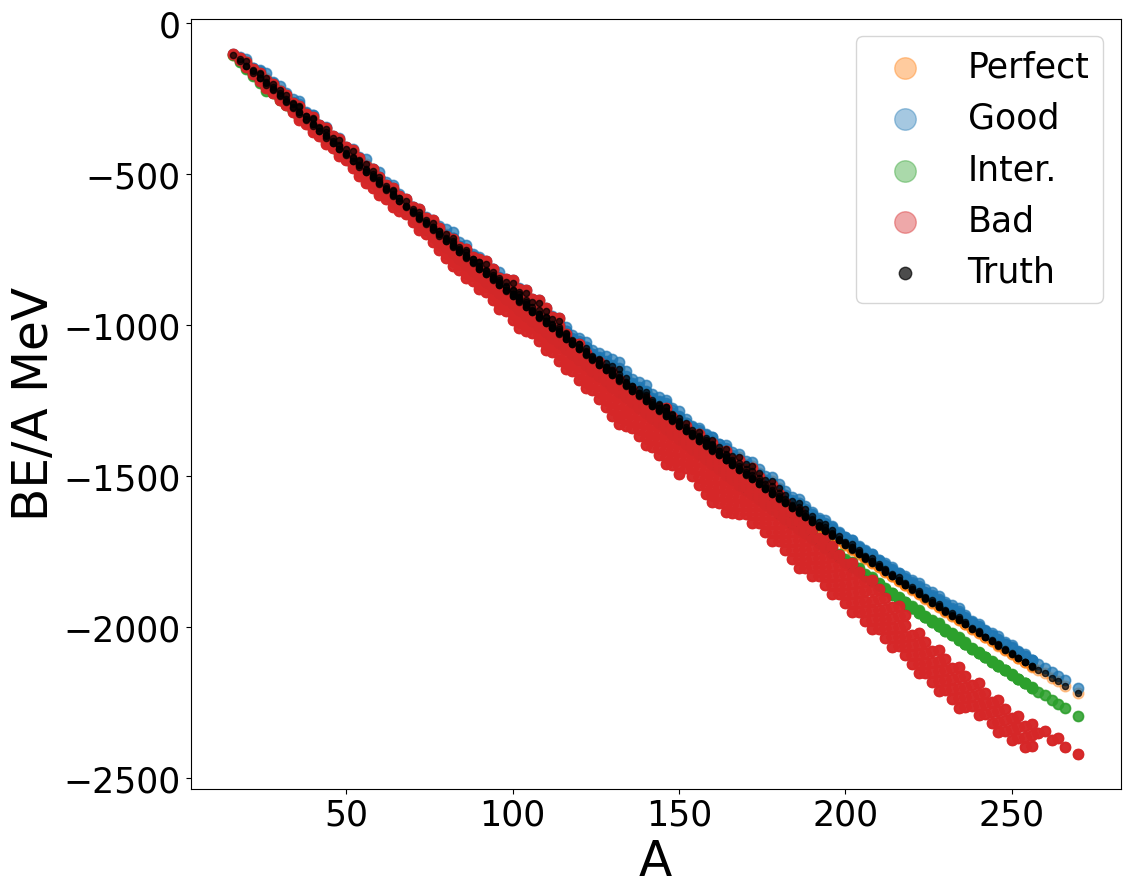

In [22]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.scatter(x = models_output["A"], y = models_output[key_list[model_index]], label = n_Labels[class_index], alpha = 0.4,color=colors[class_index],marker=markers[0],s=60)
        else:
            ax.scatter(x = models_output["A"], y = models_output[key_list[model_index]],  alpha = 0.3,color=colors[class_index],marker=markers[0],s=50)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = models_output["A"], y = models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=20)


plt.xlabel("A",fontsize=35)
plt.ylabel("BE/A MeV",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )

plt.show()

In [23]:
residuals = models_output['truth'].values[:,None] - models_output[key_list].values 

residuals_train = models_output_train['truth'].values[:,None] - models_output_train[key_list].values 

residuals_validation  = models_output_validation['truth'].values[:,None] - models_output_validation[key_list].values 

residuals_test  = models_output_test['truth'].values[:,None] - models_output_test[key_list].values 



model_predictions=models_output[key_list].values
model_predictions_train=models_output_train[key_list].values
model_predictions_validation=models_output_validation[key_list].values
model_predictions_test=models_output_test[key_list].values






model_summary = {}
model_summary["rmse_all"] = np.sqrt(np.mean(residuals ** 2, axis = 0))
model_summary["rmse_train"] = np.sqrt(np.mean(residuals_train ** 2, axis = 0))
model_summary["rmse_validation"] = np.sqrt(np.mean(residuals_validation ** 2, axis = 0))
model_summary["rmse_test"] = np.sqrt(np.mean(residuals_test ** 2, axis = 0))


model_summary_df = pd.DataFrame(model_summary, index =key_list)
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                       rmse_all  rmse_train  rmse_validation   rmse_test
PerfectModel_0         0.000000    0.000000         0.000000    0.000000
GoodModel_0           15.259736   14.398150        14.487725   16.345139
GoodModel_1           15.259736   14.398150        14.487725   16.345139
GoodModel_2           15.259736   14.398150        14.487725   16.345139
IntermediateModel_0   44.021445   38.124581        38.118607   51.001546
IntermediateModel_1   44.021445   38.124581        38.118607   51.001546
IntermediateModel_2   44.021445   38.124581        38.118607   51.001546
IntermediateModel_3   44.021445   38.124581        38.118607   51.001546
IntermediateModel_4   44.021445   38.124581        38.118607   51.001546
BadModel_0           110.587549   96.225493        99.801899  126.933950
BadModel_1           110.587549   96.225493        99.801899  126.933950
BadModel_2           110.587549   96.225493        99.801899  126.933950
BadModel_3           110.587549   96.225493        

In [24]:
model_summary_df

rmse_all  rmse_train  rmse_validation   rmse_test
PerfectModel_0         0.000000    0.000000         0.000000    0.000000
GoodModel_0           15.259736   14.398150        14.487725   16.345139
GoodModel_1           15.259736   14.398150        14.487725   16.345139
GoodModel_2           15.259736   14.398150        14.487725   16.345139
IntermediateModel_0   44.021445   38.124581        38.118607   51.001546
IntermediateModel_1   44.021445   38.124581        38.118607   51.001546
IntermediateModel_2   44.021445   38.124581        38.118607   51.001546
IntermediateModel_3   44.021445   38.124581        38.118607   51.001546
IntermediateModel_4   44.021445   38.124581        38.118607   51.001546
BadModel_0           110.587549   96.225493        99.801899  126.933950
BadModel_1           110.587549   96.225493        99.801899  126.933950
BadModel_2           110.587549   96.225493        99.801899  126.933950
BadModel_3           110.587549   96.225493        99.801899  126.933950
BadModel_4           110.587549   96.225493        99.801899  126.933950
BadModel_5           110.587549   96.225493        99.801899  126.933950
BadModel_6           110.587549   96.225493        99.801899  126.933950
BadModel_7           110.587549   96.225493        99.801899  126.933950
BadModel_8           110.587549   96.225493        99.801899  126.933950
BadModel_9           110.587549   96.225493        99.801899  126.933950

Now we prepare the data that relates to a single isotope chain for plotting

In [25]:

Z_range=(Selected_element,Selected_element)
N_range=(0,300)


filtered_models_output = models_output[(models_output['Z'] >= Z_range[0]) & (models_output['Z'] <= Z_range[1]) & 
                     (models_output['N'] >= N_range[0]) & (models_output['N'] <= N_range[1])]  

filtered_models_output_train = models_output_train[(models_output_train['Z'] >= Z_range[0]) & (models_output_train['Z'] <= Z_range[1]) & 
                     (models_output_train['N'] >= N_range[0]) & (models_output_train['N'] <= N_range[1])]

filtered_models_output_test = models_output_test[(models_output_test['Z'] >= Z_range[0]) & (models_output_test['Z'] <= Z_range[1]) & 
                     (models_output_test['N'] >= N_range[0]) & (models_output_test['N'] <= N_range[1])]

filtered_models_output_validation = models_output_validation[(models_output_validation['Z'] >= Z_range[0]) & (models_output_validation['Z'] <= Z_range[1]) & 
                     (models_output_validation['N'] >= N_range[0]) & (models_output_validation['N'] <= N_range[1])]


stable_selected_isotope=[]

for i in range(len(stable_coordinates)):
    if stable_coordinates[i][1]==Selected_element:
        stable_selected_isotope.append(stable_coordinates[i])

stable_selected_isotope=np.array(stable_selected_isotope)

# df[df['Column1'].isin(values_array)]

filtered_models_output_stable = models_output_train[(models_output_train['Z'] >= Z_range[0]) & (models_output_train['Z'] <= Z_range[1]) & 
                     (models_output_train['N'].isin(stable_selected_isotope.T[0]))]

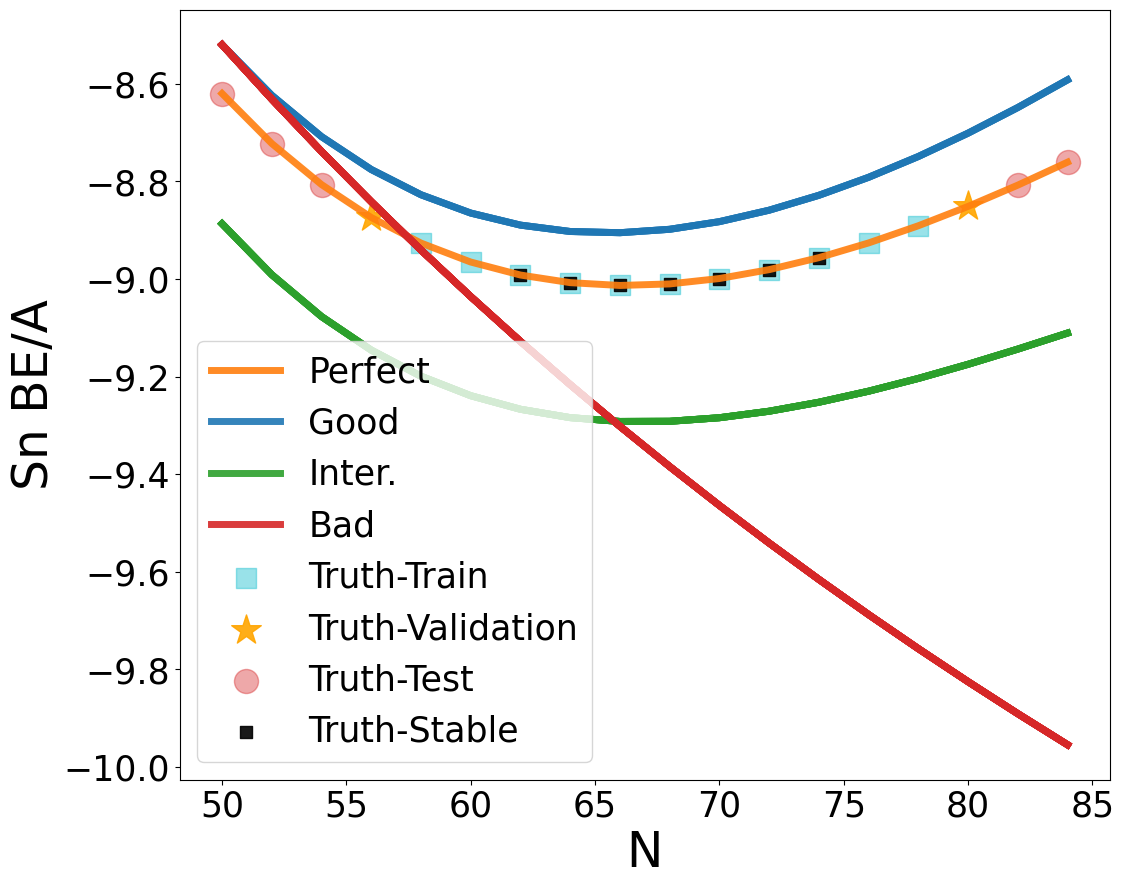

In [26]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]]/filtered_models_output['A'], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]]/filtered_models_output['A'], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0



# color_trainig=colors[9]
# color_validation='orange'
# color_testing=colors[3]

# marker_trainig='s'
# marker_validation='*'
# marker_testing='o'



# size_trainig=30
# size_validation=80
# size_testing=35

# alpha_trainig=0.8
# alpha_validation=0.9
# alpha_testing=0.4

    
    
    
    

ax.scatter(x = filtered_models_output_train["N"],
           y = filtered_models_output_train['truth']/filtered_models_output_train['A'], label = "Truth-Train",
           alpha = 0.44,color=color_trainig,s=200,marker=marker_trainig)

ax.scatter(x = filtered_models_output_validation["N"],
           y = filtered_models_output_validation['truth']/filtered_models_output_validation['A'], label = "Truth-Validation",
           alpha = 0.9,color=color_validation,s=500,marker=marker_validation)

ax.scatter(x = filtered_models_output_test["N"],
           y = filtered_models_output_test['truth']/filtered_models_output_test['A'], label = "Truth-Test",
           alpha = 0.4,color=color_testing,s=300,marker=marker_testing)

ax.scatter(x = filtered_models_output_stable["N"],
           y = filtered_models_output_stable['truth']/filtered_models_output_stable['A'], label = "Truth-Stable",
           alpha = 0.9,color='k',s=80,marker="s")







plt.xlabel("N",fontsize=35)
plt.ylabel(Selected_element_name+" BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=1 )

plt.show()

## PCA - Analysis

In [27]:
predictions_mean= np.mean(model_predictions, axis=1)
predictions_train_mean= np.mean(model_predictions_train, axis=1)
predictions_validation_mean= np.mean(model_predictions_validation, axis=1)
predictions_test_mean= np.mean(model_predictions_test, axis=1)

In [28]:
if centering_data:
    model_predictions_train_processed=np.array([model_predictions_train.T[j]-predictions_train_mean for j in range(len(model_predictions_train.T))]).T
else:
    model_predictions_train_processed=np.copy(model_predictions_train)



In [29]:
U, S, Vt = np.linalg.svd(model_predictions_train_processed)

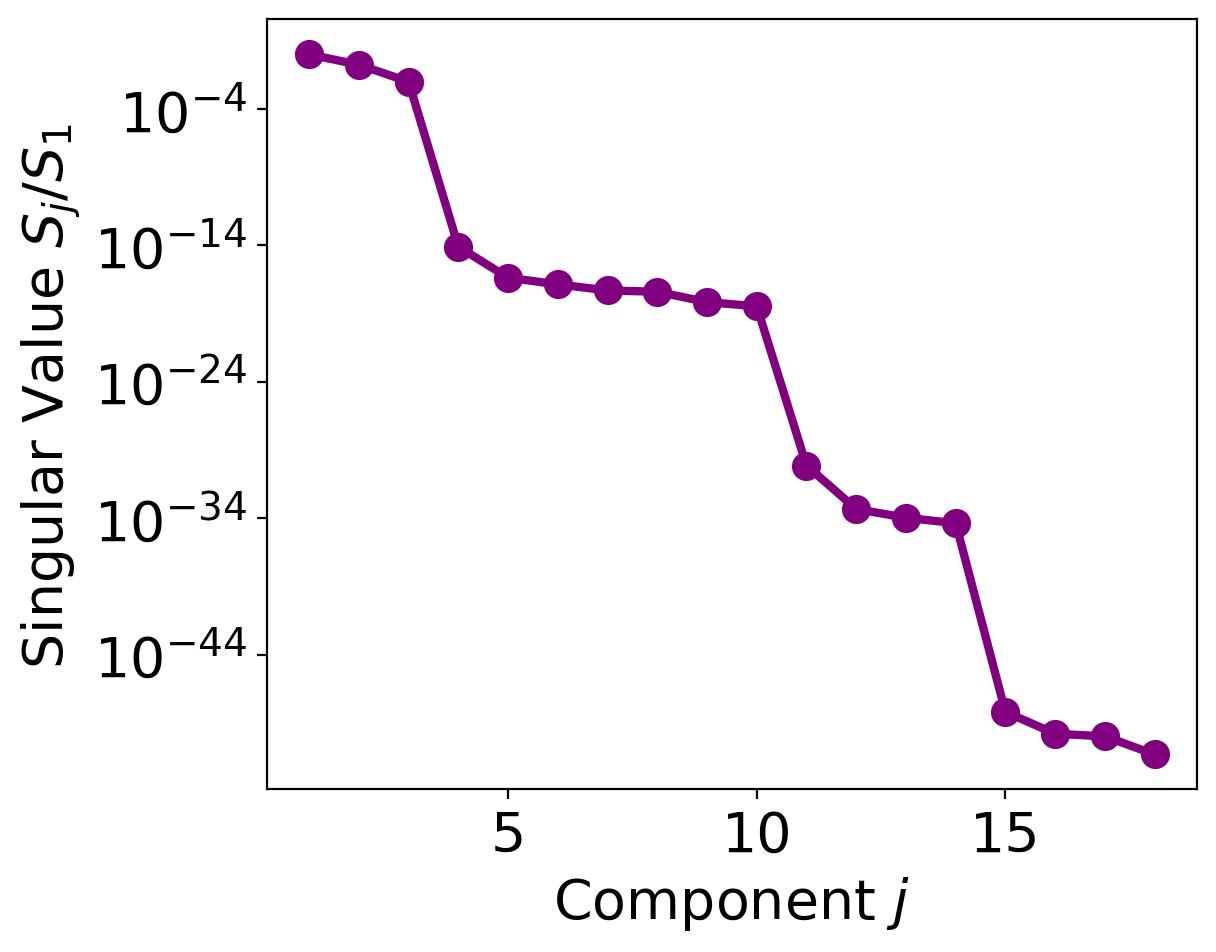

In [30]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)


fig, ax = plt.subplots(figsize=(6,5),dpi=200)
fig.patch.set_facecolor('white')

#We plot only up to n-1 singular values if we centered the data because the nth value is numerical noise ~10**(-15)
if centering_data:
    ax.scatter(np.arange(1,S.size), S[0:-1]/S[0],color='purple',s=90)
    ax.plot(np.arange(1,S.size), S[0:-1]/S[0],color='purple',linewidth=3)
else:
    ax.scatter(np.arange(1,S.size+1), S/S[0],color='purple',s=90)
    ax.plot(np.arange(1,S.size+1), S/S[0],color='purple',linewidth=3)    






# if centering_data:
#     ax.scatter(np.arange(1,S.size), S[0:-1],color='purple',s=90)
#     ax.plot(np.arange(1,S.size), S[0:-1],color='purple',linewidth=3)
# else:
#     ax.scatter(np.arange(1,S.size+1), S,color='purple',s=90)
#     ax.plot(np.arange(1,S.size+1), S,color='purple',linewidth=3)    

ax.set_yscale('log')
ax.set_xlabel(r'Component $j$',fontsize=20)
ax.set_ylabel(r' Singular Value $S_j/S_1$',fontsize=20);
# plt.ylim(2*10**(-3),1.5)
# ax.set_xticks([0,5,10,15])
# plt.title("Singular values decay",fontsize=30)
plt.show()

### How many PC we want to keep?

In [34]:
components_kept=3

In [35]:

S_hat=np.array([S[i] for i in range(components_kept)])


#No scalling at all:
U_hat=np.array([U.T[i] for i in range(components_kept)])
Vt_hat=np.array([Vt[i]/S[i] for i in range(components_kept)])

#The S needs to be absorved somewhere, either on the U or the V. We chosed the V, but we might want to have normalized Vs for plotting:
Vt_hat_normalized=np.array([Vt[i] for i in range(components_kept)])


#Scaling manually, this is something you can do if you want the PC to have a similar size as the regular models
############################

# U_hat=np.array([U.T[i]*np.linalg.norm(predictions_train_mean) for i in range(components_kept)])
# #This represents the coefficients that we use to write the normalized PC everywhere as linear combinations of the original models. It is scaled by 
# # the values of S_hat such that the norm of the PC keeps ~ constant even as we increase the number of models
# Vt_hat=np.array([Vt[i]/S_hat[i]*np.linalg.norm(predictions_train_mean) for i in range(components_kept)])   
# #These are the normalized coefficients (norm[Vt_hat_normalized[i]] is 1). We use this to plot PC projections to distinguish between clusters of models
# Vt_hat_normalized=np.array([Vt[i] for i in range(components_kept)])


if centering_data:
    num_components=components_kept+1
else:
    num_components=components_kept


In [36]:
#Creating principal components that are for training. These should be equivalent to \hat U, and if they are not there is something wrong



models_PC_train = {}

if centering_data:
    models_PC_train[str("PC_0")] = predictions_train_mean
    
for i in range(components_kept):
    models_PC_train[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_train.T)

models_PC_train["N"] = models_output_train["N"]
models_PC_train["Z"] = models_output_train["Z"]
models_PC_train["A"] = models_PC_train["N"] + models_PC_train["Z"]

models_PC_training = pd.DataFrame(models_PC_train)



In [37]:
#Creating principal components that are for validation



models_PC_validation = {}

if centering_data:
    models_PC_validation[str("PC_0")] = predictions_validation_mean
    
for i in range(components_kept):
    models_PC_validation[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_validation.T)

models_PC_validation["N"] = models_output_validation["N"]
models_PC_validation["Z"] = models_output_validation["Z"]
models_PC_validation["A"] = models_PC_validation["N"] + models_PC_validation["Z"]

models_PC_validation = pd.DataFrame(models_PC_validation)



In [38]:
#Creating principal components that are for testing



models_PC_testing = {}

if centering_data:
    models_PC_testing[str("PC_0")] = predictions_test_mean
for i in range(components_kept):
    # models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)*S_hat[i]
    models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)

models_PC_testing["N"] = models_output_test["N"]
models_PC_testing["Z"] = models_output_test["Z"]
models_PC_testing["A"] = models_PC_testing["N"] + models_PC_testing["Z"]

models_PC_testing = pd.DataFrame(models_PC_testing)






In [39]:
#Creating principal components that are valid everywhere (testing + training + validation)
models_PC = {}

if centering_data:
    models_PC[str("PC_0")] = predictions_mean

for i in range(components_kept):
    models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)

models_PC = pd.DataFrame(models_PC)
models_PC["N"] = Full_set.T[0]
models_PC["Z"] = Full_set.T[1]
models_PC["A"] = models_PC["N"] + models_PC["Z"]

In [40]:
#Creating principal components that are focused on the isotope chain we specified before

filtered_models_PC = models_PC[(models_PC['Z'] >= Z_range[0]) & (models_PC['Z'] <= Z_range[1]) & 
                     (models_PC['N'] >= N_range[0]) & (models_PC['N'] <= N_range[1])]

In [41]:
key_list_PCs=list(filtered_models_PC.keys())

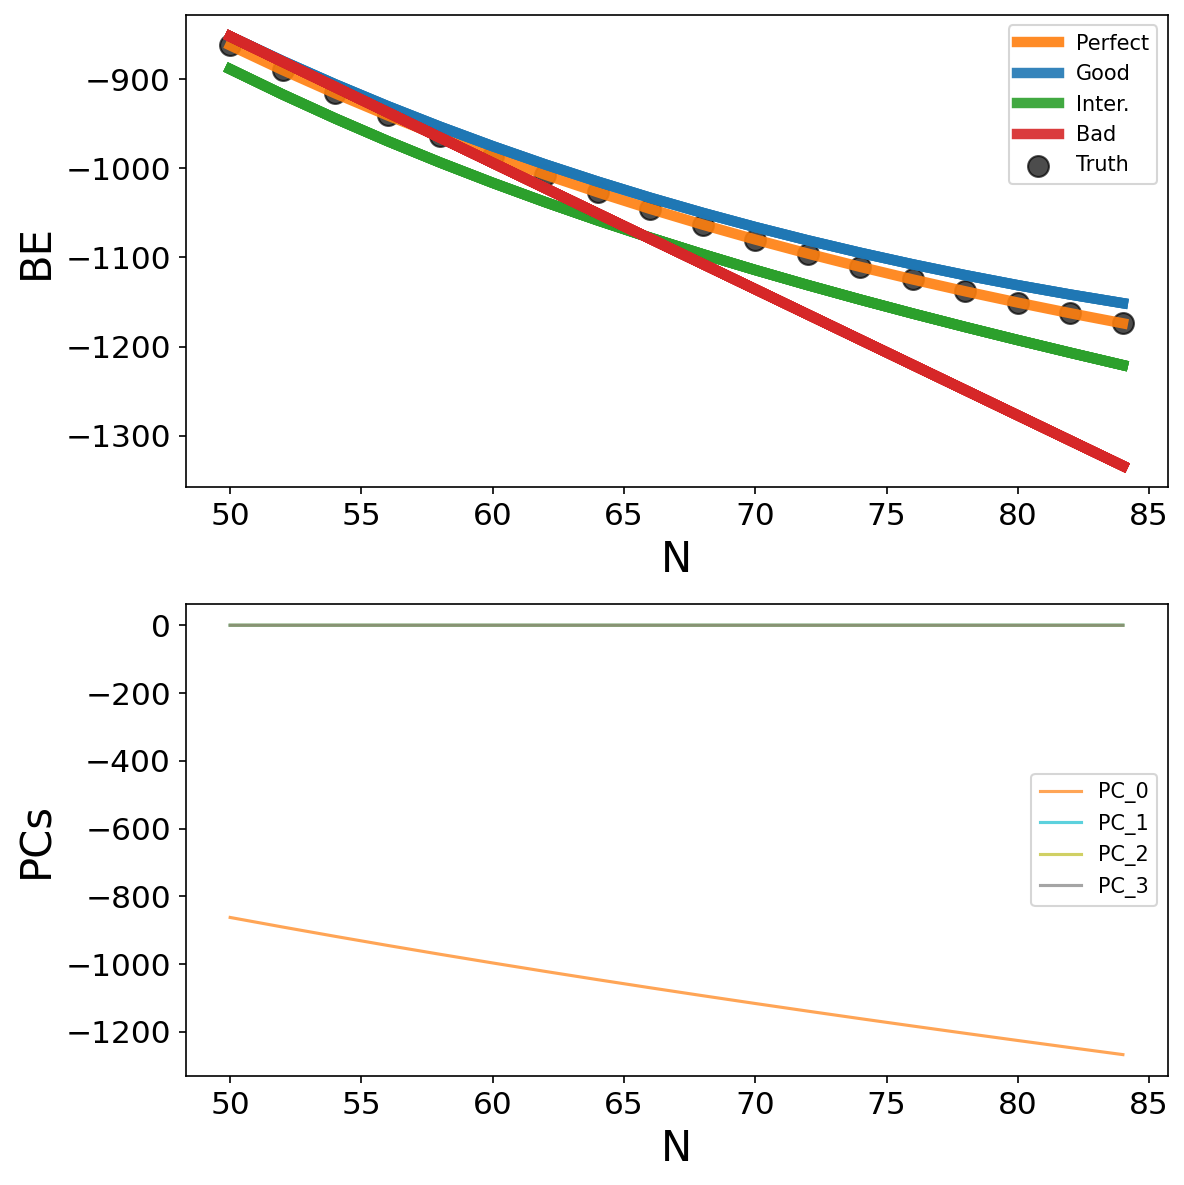

In [42]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# fig, ax = plt.subplots(figsize=(12,10), dpi=100)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8),dpi=150)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax1.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax1.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0

ax1.scatter(x = filtered_models_output["N"], y = filtered_models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=100)

ax1.set_xlabel("N",fontsize=20)
ax1.set_ylabel("BE",fontsize=20)
ax1.legend( )

for i in range(num_components):
    ax2.plot(filtered_models_PC["N"], filtered_models_PC[key_list_PCs[i]], label =key_list_PCs[i], alpha = 0.7,color=colors[-i])

ax2.set_xlabel("N",fontsize=20)
ax2.set_ylabel("PCs",fontsize=20)
ax2.legend()





plt.tight_layout()

plt.show()

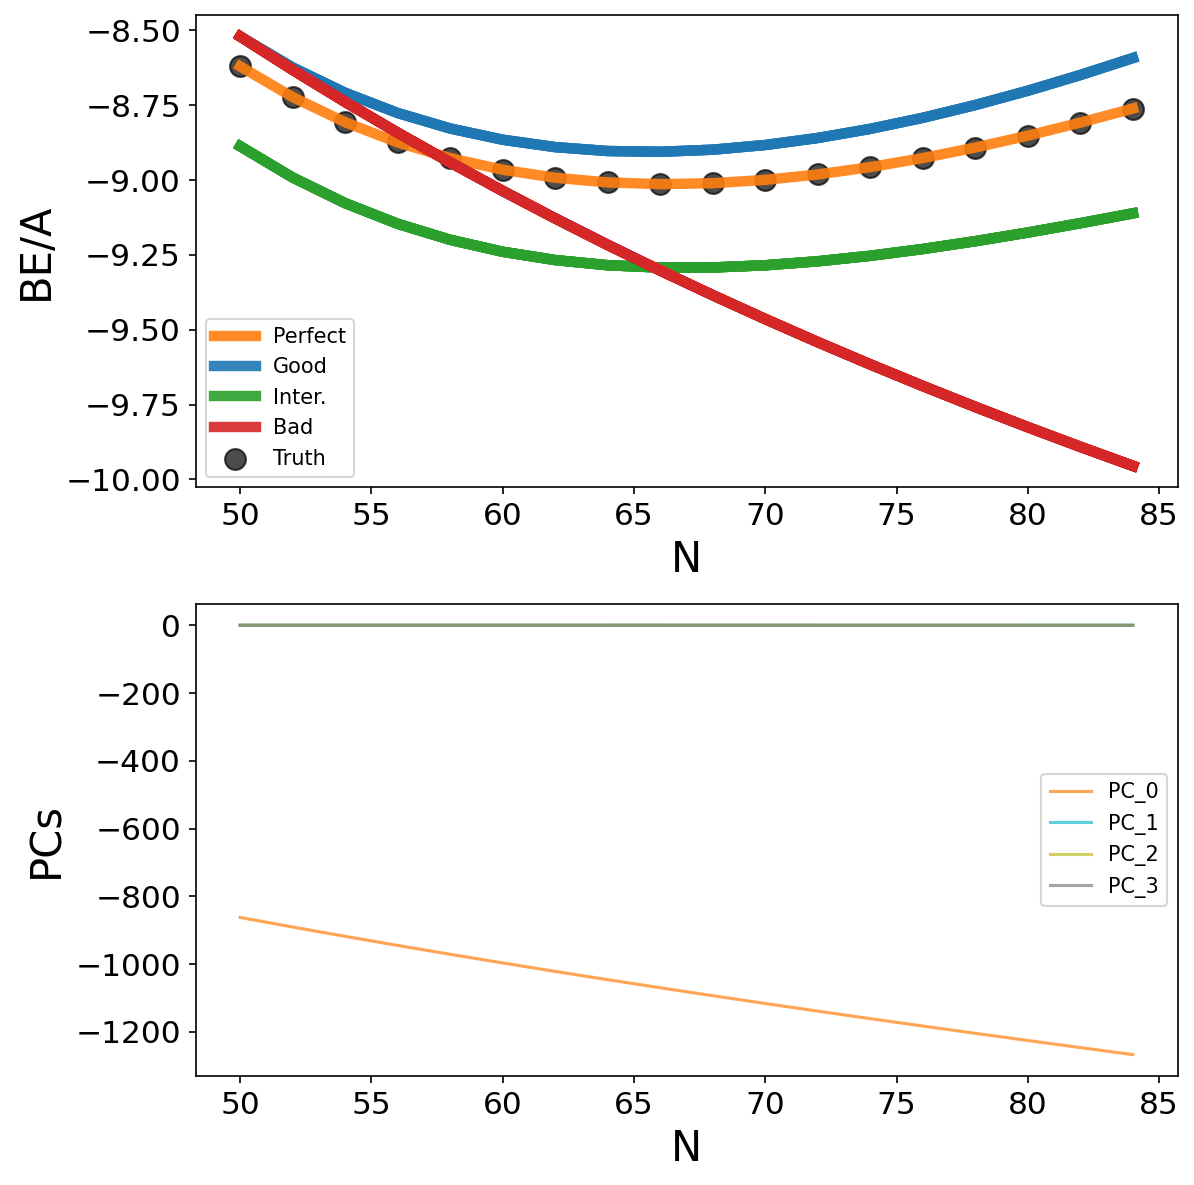

In [43]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# fig, ax = plt.subplots(figsize=(12,10), dpi=100)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8),dpi=150)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax1.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]]/filtered_models_output["A"], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax1.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]]/filtered_models_output["A"], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0

ax1.scatter(x = filtered_models_output["N"], y = filtered_models_output['truth']/filtered_models_output["A"], label = "Truth", alpha = 0.7,color='k',s=100)

ax1.set_xlabel("N",fontsize=20)
ax1.set_ylabel("BE/A",fontsize=20)
ax1.legend( )

for i in range(num_components):
    ax2.plot(filtered_models_PC["N"], filtered_models_PC[key_list_PCs[i]], label =key_list_PCs[i], alpha = 0.7,color=colors[-i])

ax2.set_xlabel("N",fontsize=20)
ax2.set_ylabel("PCs",fontsize=20)
ax2.legend()





plt.tight_layout()

plt.show()

### Making some 3D plots of the PCs

In [44]:
x_values=models_PC["N"].tolist()
y_values=models_PC["Z"].tolist()
pc_data=[]

if centering_data:
    pc_data.append([x_values,y_values,models_PC["PC_0"].tolist()])

for i in range(components_kept):
    pc_data.append([x_values,y_values,models_PC[str("PC_")+str(i+1)].tolist()])

    
pc_data=np.array(pc_data)    

In [45]:
PlotMultiple(pc_data,[30,-90])

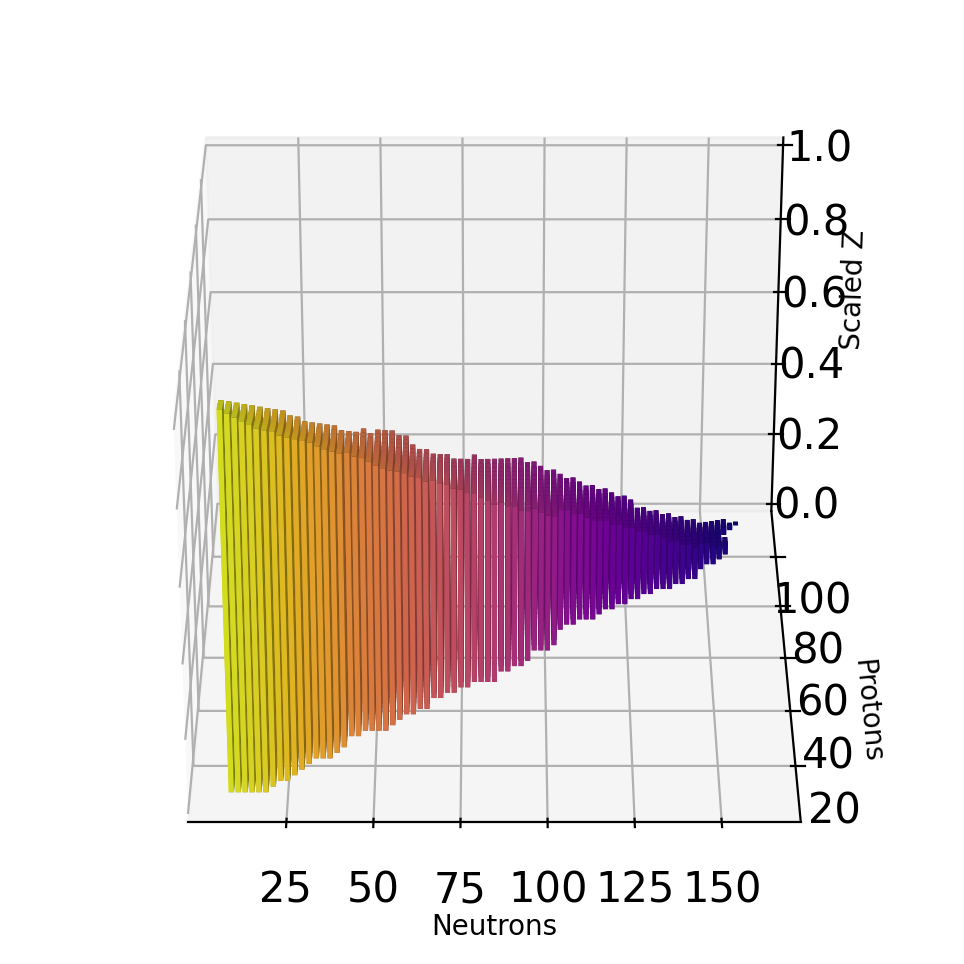

In [ ]:
#If we want to see some of them in more detail

Plotter3D_single(pc_data[0],elev=30,azim=-90)

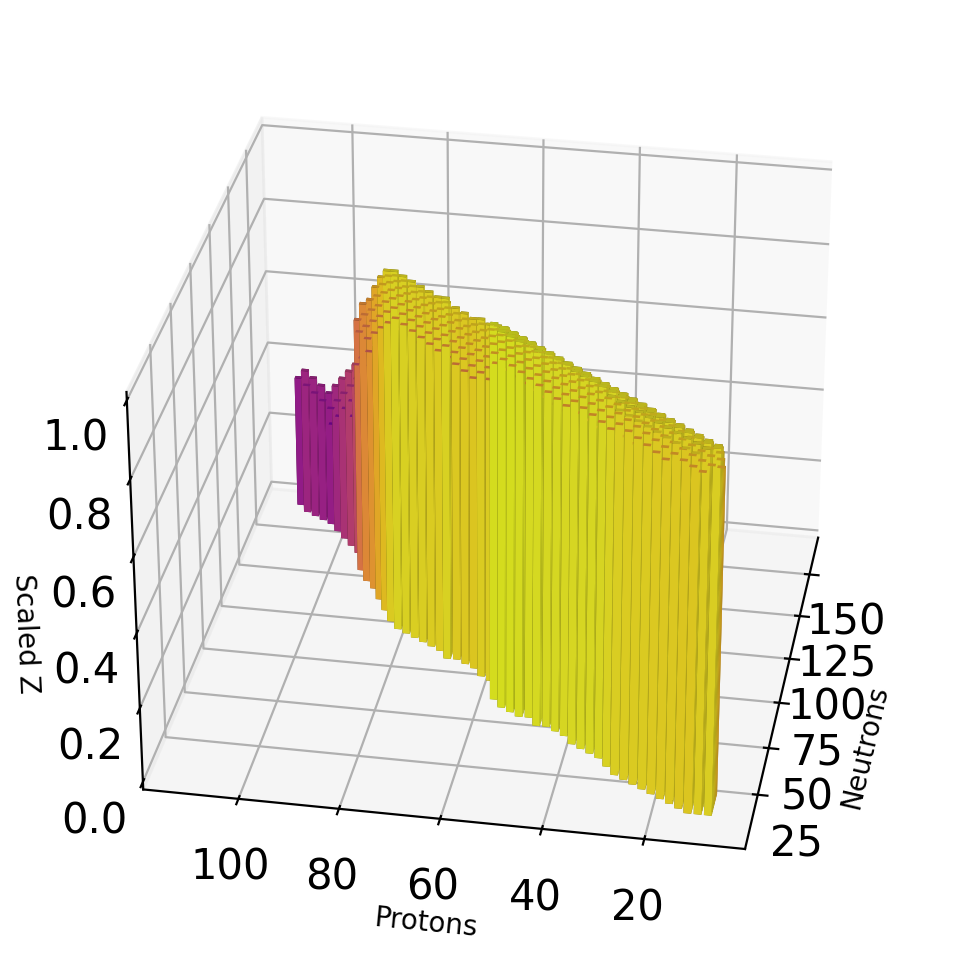

In [ ]:
Plotter3D_single(pc_data[1],elev=30,azim=-170)

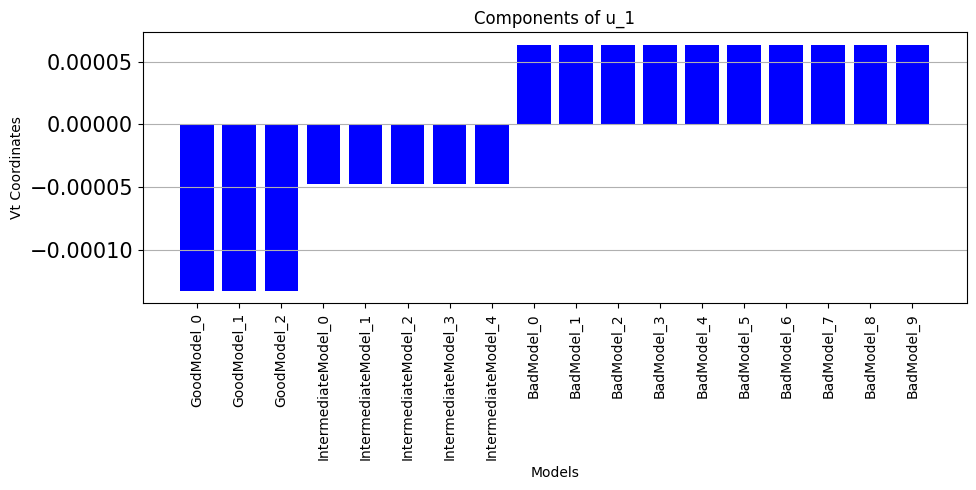

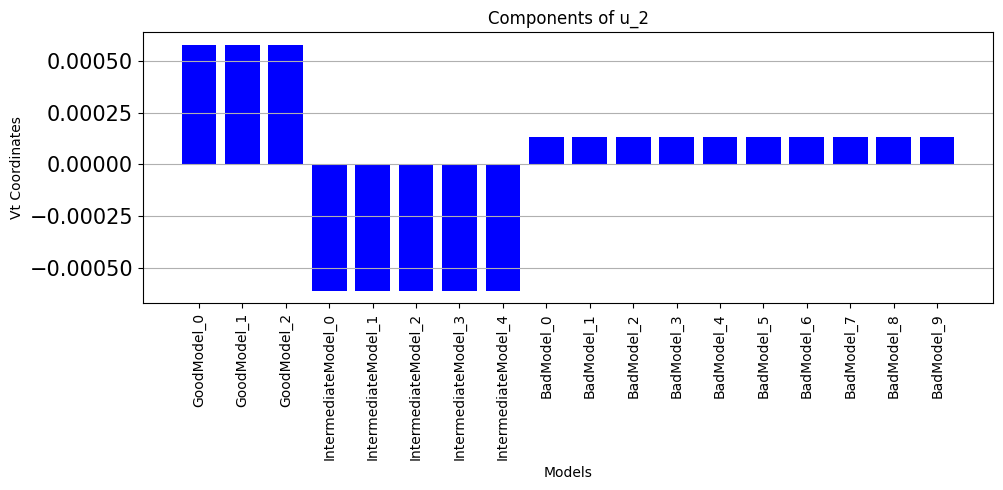

In [ ]:
#We can also see how the PC are made up from the different models


for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], key_list, title=f"Components of u_{i+1}", color='blue')

### Plotting the projections of each model on the PCs

/tmp/ipykernel_22729/3246472634.py:36: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


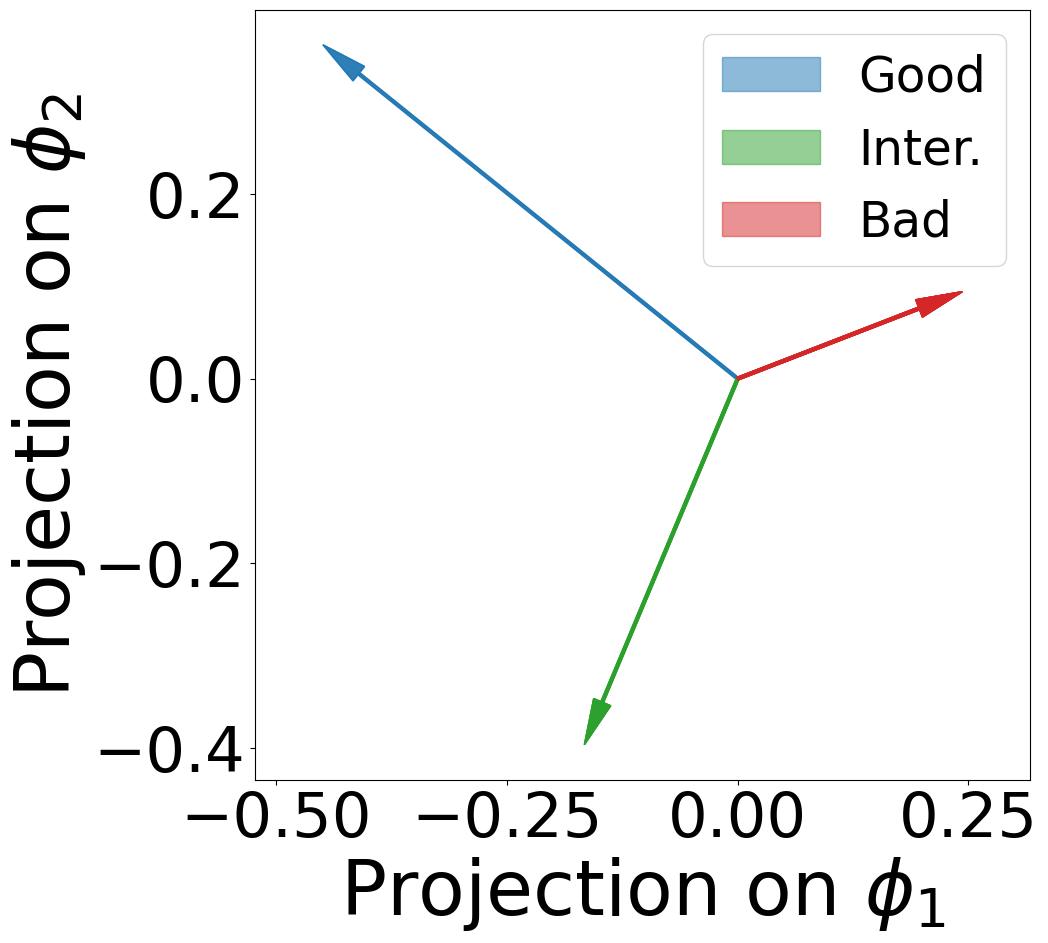

In [ ]:

plt.rc("xtick", labelsize=45)
plt.rc("ytick", labelsize=45)

fig, ax = plt.subplots(figsize=(10,10), dpi=100)

model_index=0
class_index=0

visited_model=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1

            ax.arrow(0, 0, Vt_hat_normalized.T[visited_model][0],Vt_hat_normalized.T[visited_model][1],width=0.003, head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],label=n_Labels[class_index],alpha=0.6)
           
        else:
            ax.arrow(0, 0, Vt_hat_normalized.T[visited_model][0], Vt_hat_normalized.T[visited_model][1],width=0.003, head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],alpha=0.6)
        model_index=model_index+1
        visited_model=visited_model+1
    class_index=class_index+1
    legend_flag=0


# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-0.25, 0.9)

# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on $\phi_1$',fontsize=55)
plt.ylabel('Projection on $\phi_2$',fontsize=55)

legend = plt.legend(fontsize=35)
for handle in legend.legendHandles:
    handle.set_alpha(0.5)

# plt.legend(loc=(0.49, 0.7),fontsize=32)
# plt.legend(fontsize=32)
# ax.set_xticks([-0.2,0,0.2,0.4,0.6])
plt.axis('equal')
# plt.xlim(-0.3, 0.6)
# plt.ylim(-0.43, 0.5)

plt.show()


In [ ]:
#If we kept more than one PC we can project on that one too

if components_kept>2:

    plt.rc("xtick", labelsize=30)
    plt.rc("ytick", labelsize=30)

    fig, ax = plt.subplots(figsize=(10,8), dpi=100)

    model_index=0
    class_index=0

    visited_model=0
    for n_vals in n_classes:
        legend_flag=0
        for i in range(n_vals):
            if legend_flag==0:
                legend_flag=1

                plt.arrow(0, 0, Vt_hat_normalized.T[visited_model][1], Vt_hat_normalized.T[visited_model][2], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],label=n_Labels[class_index])
            
            else:
                plt.arrow(0, 0, Vt_hat_normalized.T[visited_model][1], Vt_hat_normalized.T[visited_model][2], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index])
            model_index=model_index+1
            visited_model=visited_model+1
        class_index=class_index+1
        legend_flag=0


    # Determine plot limits based on the maximum absolute values of the vectors
    # max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
    # plt.xlim(-max_val-1, max_val+1)
    # plt.ylim(-max_val-1, max_val+1)

    plt.xlabel('Projection on PC 2',fontsize=35)
    plt.ylabel('Projection on PC 3',fontsize=35)

    plt.legend(loc=(0.015, 0.32),fontsize=27)

    plt.axis('equal')

    plt.show()


## Calibration section: learning weight distributions from data

In [ ]:
X=np.copy(U_hat)
if centering_data:
    y=np.copy(models_output_train["truth"].tolist())-predictions_train_mean
else:
    y=np.copy(models_output_train["truth"].tolist())

In [ ]:
#Making the list of principal components across the train part. These should be identical to the X on top made by \hat U
X_train=[]
for i in range(num_components):
    X_train.append(models_PC_train[key_list_PCs[i]].tolist() )
# if centering_data==True:
#     for i in range(num_components):
#         X_train.append(models_PC_train[key_list_PCs[i]].tolist() )

# else:
#     for i in range(num_components):
#         X_train.append(models_PC_train[key_list_PCs[i]].tolist())

X_train=np.array(X_train)

In [ ]:
#Making the list of principal components across the validation part
X_validation=[]
for i in range(num_components):
    X_validation.append(models_PC_validation[key_list_PCs[i]].tolist())
# if centering_data==True:
#     for i in range(num_components):
#         X_validation.append(models_PC_validation[key_list_PCs[i]].tolist())
# else:
#     for i in range(num_components):
#         X_validation.append(models_PC_validation[key_list_PCs[i]].tolist())
X_validation=np.array(X_validation)

In [ ]:
#Making the list of principal components across the testing part
X_test=[]
for i in range(num_components):
    X_test.append(models_PC_testing[key_list_PCs[i]].tolist())

# if centering_data==True:
#     for i in range(num_components):
#         X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
# else:
#     for i in range(num_components):
#         X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
X_test=np.array(X_test)

In [ ]:
#Making the list of principal components across the entire chart (training+validation+testing)
X_full=[]
for i in range(num_components):
    X_full.append(models_PC[key_list_PCs[i]].tolist())
# if centering_data==True:
#     for i in range(num_components):
#         X_full.append(models_PC[key_list_PCs[i]].tolist())
# else:
#     for i in range(num_components):
#         X_full.append(models_PC[key_list_PCs[i]].tolist())
X_full=np.array(X_full)

## Unconstrained approach with empirical noise (linear algebra)

In [ ]:
# 1) Find the least square solution for the training part
X_T_X=X.dot(X.T)
X_T_X_inv = np.linalg.inv(X_T_X)

beta = X_T_X_inv.dot(X).dot(y)

# if centering_data==True:
#     supermodel=X.T.dot(beta) + predictions_train_mean
# else:
#     supermodel=X.T.dot(beta)

#1.5) Construct the super model across the entire range and the test range
if centering_data:
    beta_full= np.insert(beta, 0, 1)  #Augmenting the beta list to add a "1" at the begining so it can use the PC0 (the mean)
else:
    beta_full=np.copy(beta)



supermodel=X_train.T.dot(beta_full)

supermodel_train=X_train.T.dot(beta_full)
# supermodel_train=np.copy(supermodel)

supermodel_validation=X_validation.T.dot(beta_full)
supermodel_test=X_test.T.dot(beta_full)
supermodel_full=X_full.T.dot(beta_full)


# 2) Construct the covariance matrix
if centering_data==True:
    residuals = y - supermodel + predictions_train_mean
else:
    residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=500000)


In [ ]:
sigma_squared

4.15468282627851

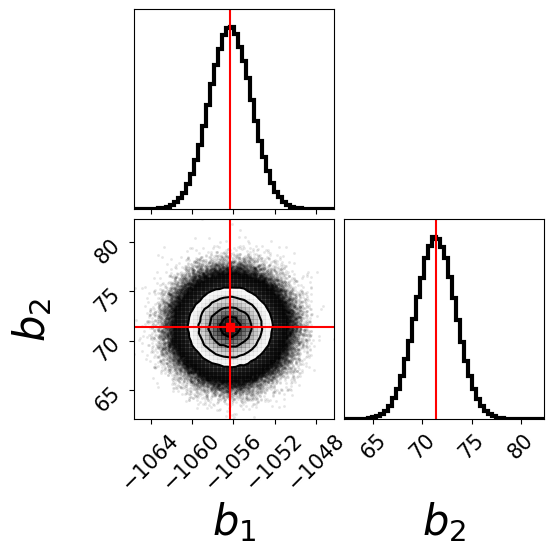

In [ ]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(samples,bins=50, dpi=300, hist_kwargs={"linewidth": 3},
                       labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)], truths=beta,truth_color="r",
                       label_kwargs={"fontsize": 30},labelpad=0.1)


plt.show()

### We can make a plot on the original space from the latent observation. By default is commented out because it might take a couple of minutes

In [ ]:
# if centering_data:
#     samples_naive_space = np.array([np.dot(betaval,Vt_hat) + np.full(len(Vt_hat.T),1/len(Vt_hat.T)) for  betaval in samples])
#     figure = corner.corner(samples_naive_space, bins=50, hist_kwargs={"linewidth": 3},labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat)+ np.full(len(Vt_hat.T),1/len(Vt_hat.T)),label_kwargs={"fontsize": 20})
# else:
#     samples_naive_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])
#     figure = corner.corner(samples_naive_space, bins=50, dpi=300, hist_kwargs={"linewidth": 3},labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat),label_kwargs={"fontsize": 30})

# plt.show()


: 

## Unconstrained approach with unknown variance (MC sampling)

In [ ]:
def gibbs_sampler(y, X, iterations,prior_info):
    #Make sure that "y" has the correct structure. If data is being centered, it should have the mean already substracted
    b_mean_prior, b_mean_cov, nu0, sigma20  =  prior_info
    #From A_First_Course_in_Bayesian_Statistical_Methods (page ~ 159), nu0 represent the effective prior samples and sigma2_0 represents the expected prior variance
    
    b_mean_cov_inv=np.linalg.inv(b_mean_cov)
    
    
    n = len(y)
    X_T_X=X.dot(X.T)
    X_T_X_inv = np.linalg.inv(X_T_X)

    b_data = X_T_X_inv.dot(X).dot(y)

    
    
    supermodel=X_train[1:].T.dot(b_data)
    

    residuals = y - supermodel 

    
    
    sigma2 = np.sum(residuals**2) / len(residuals) 
    cov_matrix = sigma_squared * X_T_X_inv
    
    samples = []
    
    for i in range(iterations):
        # Sample from the conditional posterior of bs given sigma2 and data

        
        cov_matrix = np.linalg.inv(X_T_X/sigma2
                                   + b_mean_cov_inv)
        
        mean_vector = cov_matrix.dot(        b_mean_cov_inv.dot(b_mean_prior)+ X.dot(y)/sigma2  )
        
        
        b_current = np.random.multivariate_normal(mean_vector, cov_matrix)

        
        
        
        # Sample from the conditional posterior of sigma2 given bs and data
        supermodel=X_train[1:].T.dot(b_current)
        
        residuals = y - supermodel 
        
        
        shape_post = (nu0 + n)/2.
        scale_post = (nu0*sigma20 + np.sum(residuals**2))/2.0
        # sigma2 = 1 / np.random.gamma(shape_post, 1/scale_post)
        sigma2 = 1 / np.random.default_rng().gamma(shape_post, 1/scale_post)
        
        
        samples.append(np.append(b_current,np.sqrt(sigma2)))
    


    return np.array(samples)

In [329]:
S_hat

array([3101.66558362,  571.3013592 ])

In [330]:
res_gibbs=gibbs_sampler(y, X, 50000,[np.full(components_kept,0),np.abs(np.diag(S_hat**2)), 10, 5])

In [331]:
labels_MC=[f'$b_{i}$' for i in range(1, len(beta) + 1)]
labels_MC.append(f'$\sigma$')

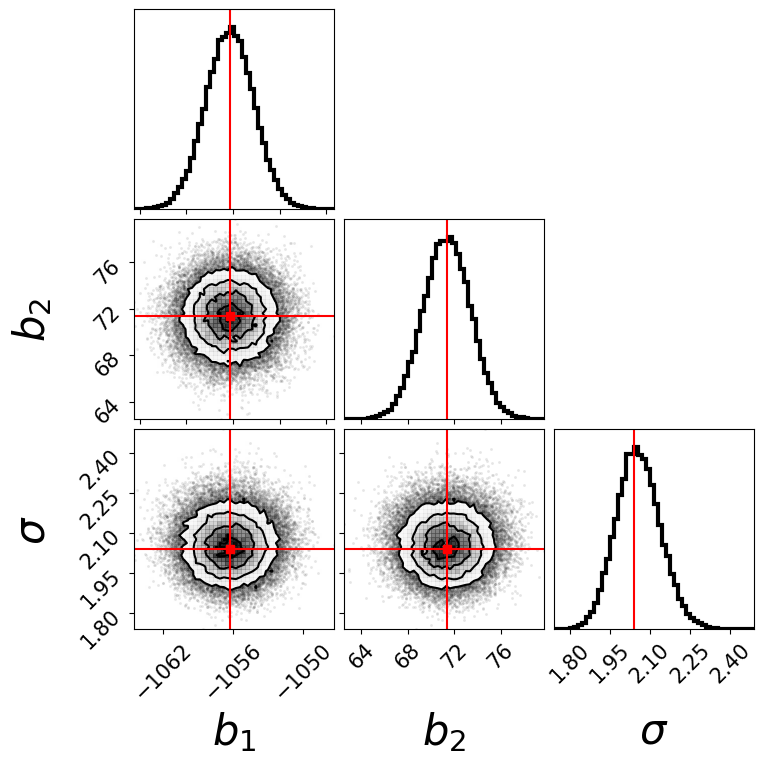

In [332]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(res_gibbs,bins=50, dpi=300, hist_kwargs={"linewidth": 3},
                       labels=labels_MC, truths=np.append(beta,np.sqrt(sigma_squared)),truth_color="r",
                       label_kwargs={"fontsize": 30},labelpad=0.1)



ndim=len(res_gibbs[0])

# Access the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

ax=axes[2,0]           
ax.locator_params(nbins=3, axis='x')            
            
plt.show()


plt.show()

## We now follow the same sampling (unconstrained) but using the full space of models (naive BMM)

In [334]:
X_naive=np.copy(model_predictions_train).T
X_full_naive=np.copy(model_predictions).T
X_test_naive=np.copy(model_predictions_test).T
X_validation_naive=np.copy(model_predictions_validation).T

y_naive=np.copy(models_output_train["truth"].tolist())
y_naive_test=np.copy(models_output_test["truth"].tolist())
y_naive_validation=np.copy(models_output_validation["truth"].tolist())
y_naive_full=np.copy(models_output["truth"].tolist())



In [335]:
#Same process on the naive space of full models    

# 1) Find the least square solution for the training part
X_T_X_naive=X_naive.dot(X_naive.T)
X_T_X_inv_naive = np.linalg.inv(X_T_X_naive)
beta_naive = X_T_X_inv_naive.dot(X_naive).dot(y_naive)
supermodel_naive=X_naive.T.dot(beta_naive)

#1.5) Construct the super model across the entire range and the test range
supermodel_train_naive=np.copy(supermodel_naive)
supermodel_full_naive=X_full_naive.T.dot(beta_naive)
supermodel_test_naive=X_test_naive.T.dot(beta_naive)
supermodel_validation_naive=X_validation_naive.T.dot(beta_naive)


# 2) Construct the covariance matrix
residuals_naive = y_naive - supermodel_naive
sigma_squared_naive = np.sum(residuals_naive**2) / len(residuals_naive) 
cov_matrix_naive = sigma_squared_naive * X_T_X_inv_naive

# 3) Make a corner plot
samples_naive = np.random.multivariate_normal(beta_naive, cov_matrix_naive, size=50000)


LinAlgError: Singular matrix

### Uncomment the next cell to make the corner plot (might take a couple of minutes)

In [ ]:
# figure = corner.corner(samples_naive, bins=50, dpi=300, hist_kwargs={"linewidth": 3},labels=[f'$w_{i}$' for i in range(1,1+len(beta_naive))], truths=beta_naive,label_kwargs={"fontsize": 30})
# # figure = corner.corner(samples_naive_space)

# plt.show()

In [ ]:
beta_naive

array([ 0.15568178,  0.85111666, -0.03018734])

### Making a correlation matrix plot of the weights obtained by the naive BMM

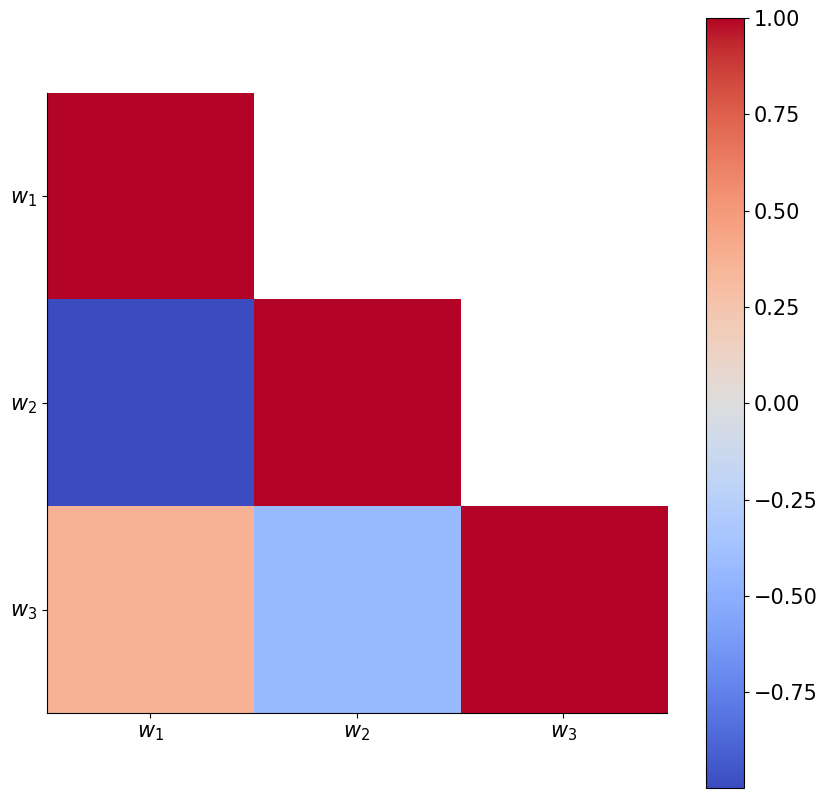

In [ ]:
correlation_matrix_naive = cov_matrix_naive / np.sqrt(np.outer(np.diag(cov_matrix_naive), np.diag(cov_matrix_naive)))

mask = np.triu_indices_from(correlation_matrix_naive, k=1)
correlation_matrix_naive[mask] = np.nan

fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap

# cax = ax.matshow(correlation_matrix_naive, cmap='coolwarm', vmin=0.99925, vmax=1)
cax = ax.matshow(correlation_matrix_naive, cmap='coolwarm')
# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(correlation_matrix_naive)))
ax.set_yticks(np.arange(len(correlation_matrix_naive)))

plot_labels=[f"$w_{{{i}}}$" for i in range(1, len(correlation_matrix_naive) + 1)]
ax.set_xticklabels(plot_labels)
ax.set_yticklabels(plot_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.tick_bottom()

# Show the plot
plt.show()

### Making a correlation plot in the space of the bs. For the unconstrained case it should be just a boring diagonal matrix

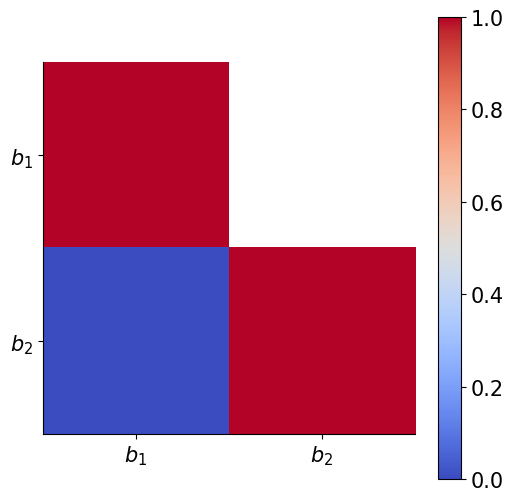

In [ ]:
correlation_matrix = cov_matrix / np.sqrt(np.outer(np.diag(cov_matrix), np.diag(cov_matrix)))

mask = np.triu_indices_from(correlation_matrix, k=1)
correlation_matrix[mask] = np.nan

fig, ax = plt.subplots(figsize=(6, 6))

# Create the heatmap

# cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(correlation_matrix)))
ax.set_yticks(np.arange(len(correlation_matrix)))

plot_labels=[f"$b_{i}$" for i in range(1, len(correlation_matrix) + 1)]

ax.set_xticklabels(plot_labels)
ax.set_yticklabels(plot_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.tick_bottom()

# Show the plot
plt.show()

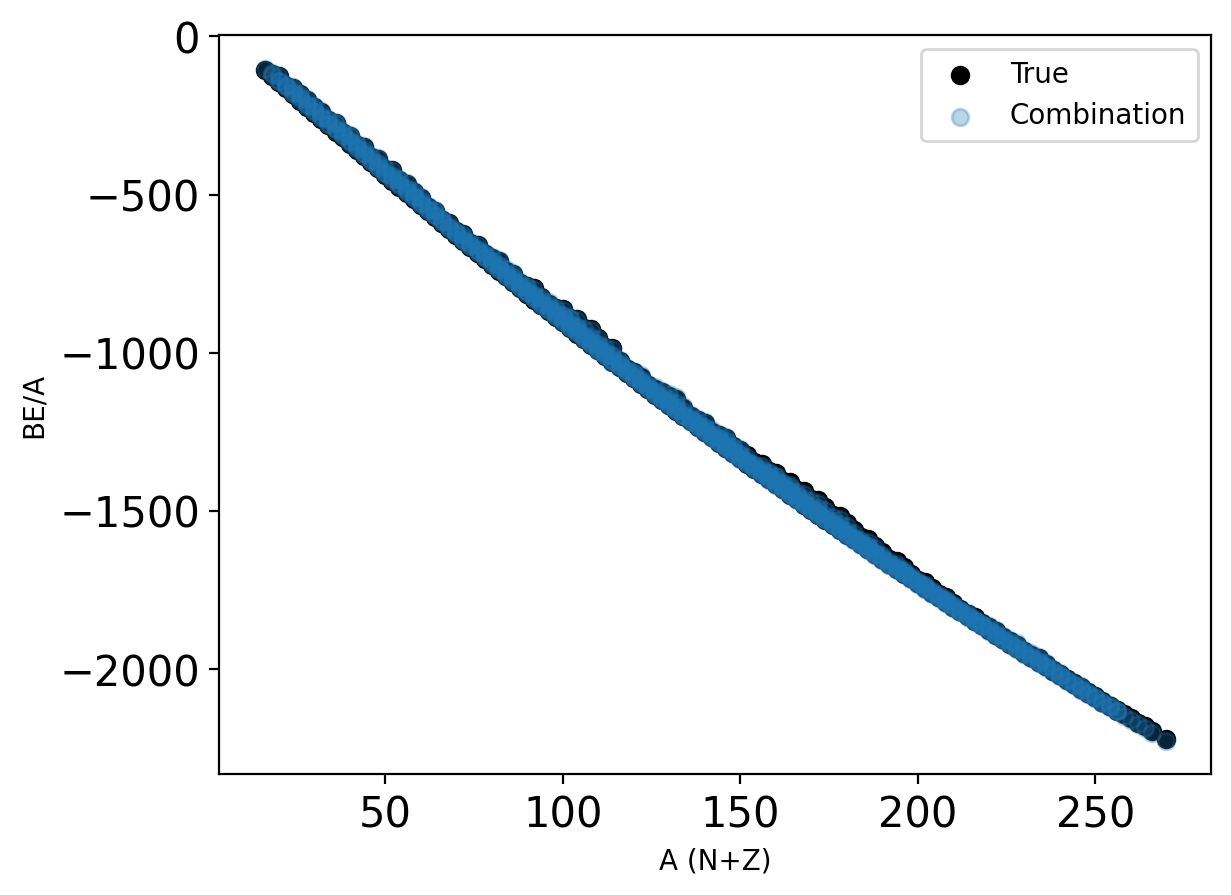

In [ ]:
fig = plt.subplots(dpi=200)

plt.scatter(x = models_output["A"], y = models_output['truth'], label = str("True"), color='k')




plt.scatter(x = models_output["A"], y = supermodel_full, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

### Making a plot of the calibrated models on the isotope of interest

### First the BMM with PCs (space of bs)

Choose next cell if you want to use the samples from unconstrained and estimated sigma

In [ ]:
# #Restricting the super model to plot on the selected isotope 
# X_full_filtered=[]

# for i in range(len(X_full)):
#     X_full_filtered.append(X_full[i][filtered_models_output.index])
# X_full_filtered=np.array(X_full_filtered)

# rng = np.random.default_rng()


# #Chose this for when the sampling was done without constraint
# ####################
# theta_rand = rng.choice(samples, (50000), replace=False)
# appropiate_sigma=sigma_squared


# rndm_m = []

# for i in range(len(theta_rand)):
#     if centering_data:
#         yvals_rand= X_full_filtered.T.dot(np.insert(theta_rand[i], 0, 1))
#     else:
#         yvals_rand= X_full_filtered.T.dot(theta_rand[i])

#     rndm_m.append(yvals_rand +
#                    np.random.multivariate_normal(np.full(
#                        len(yvals_rand)
#                        ,0), np.diag(1.0 * np.full(len(yvals_rand),1.0 * appropiate_sigma ) )))   
    




Choose next cell if you want to use the GIBBS samples from unconstrained

In [336]:

#Restricting the super model to plot on the selected isotope 
X_full_filtered=[]

for i in range(len(X_full)):
    X_full_filtered.append(X_full[i][filtered_models_output.index])
X_full_filtered=np.array(X_full_filtered)

rng = np.random.default_rng()


###################
theta_rand = rng.choice(res_gibbs, min((100000),len(res_gibbs)), replace=False)
# appropiate_sigma=sigma_squared


rndm_m = []

for i in range(len(theta_rand)):
    if centering_data:
        yvals_rand= X_full_filtered.T.dot(np.insert(theta_rand[i][0:-1], 0, 1))
    else:
        yvals_rand= X_full_filtered.T.dot(theta_rand[i][0:-1])

    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(yvals_rand)
                       ,0), np.diag(1.0 * np.full(len(yvals_rand),1.0 * theta_rand[i][-1]**2 ) )))   

In [337]:
# if computing_MCMC:
#     theta_rand_MCMC = rng.choice(met_res[0], (50000), replace=False)
#     appropiate_sigma_MCMC=emp_sigma**2

#     rndm_m_MCMC = []

#     for i in range(len(theta_rand_MCMC)):
#         if centering_data:
#             yvals_rand= X_full_filtered.T.dot(np.insert(theta_rand_MCMC[i], 0, 1))
#         else:
#             yvals_rand= X_full_filtered.T.dot(theta_rand_MCMC[i])

#         rndm_m_MCMC.append(yvals_rand +
#                     np.random.multivariate_normal(np.full(
#                         len(yvals_rand)
#                         ,0), np.diag(1.0 * np.full(len(yvals_rand),1.0 * appropiate_sigma_MCMC ) )))   

### Second (if we want) the BMM with all models (space of ws)

In [338]:
# `#Restricting the full naive model to the isotopes we want
# model_predictions_filtered=[]

# for i in range(len(model_predictions.T)):
#     model_predictions_filtered.append(model_predictions.T[i][filtered_models_output.index])
# model_predictions_filtered=np.array(model_predictions_filtered)

# rndm_m_naive=[]

# for i in range(len(samples_naive)):

#     yvals_rand= model_predictions_filtered.T.dot(samples_naive[i])

#     rndm_m_naive.append( ( yvals_rand +
#                    np.random.multivariate_normal(np.full(
#                        len(yvals_rand)
#                        ,0), np.diag(1.0 * np.full(len(yvals_rand),1.0 * sigma_squared_naive ) )))/filtered_models_output["A"]      )   `

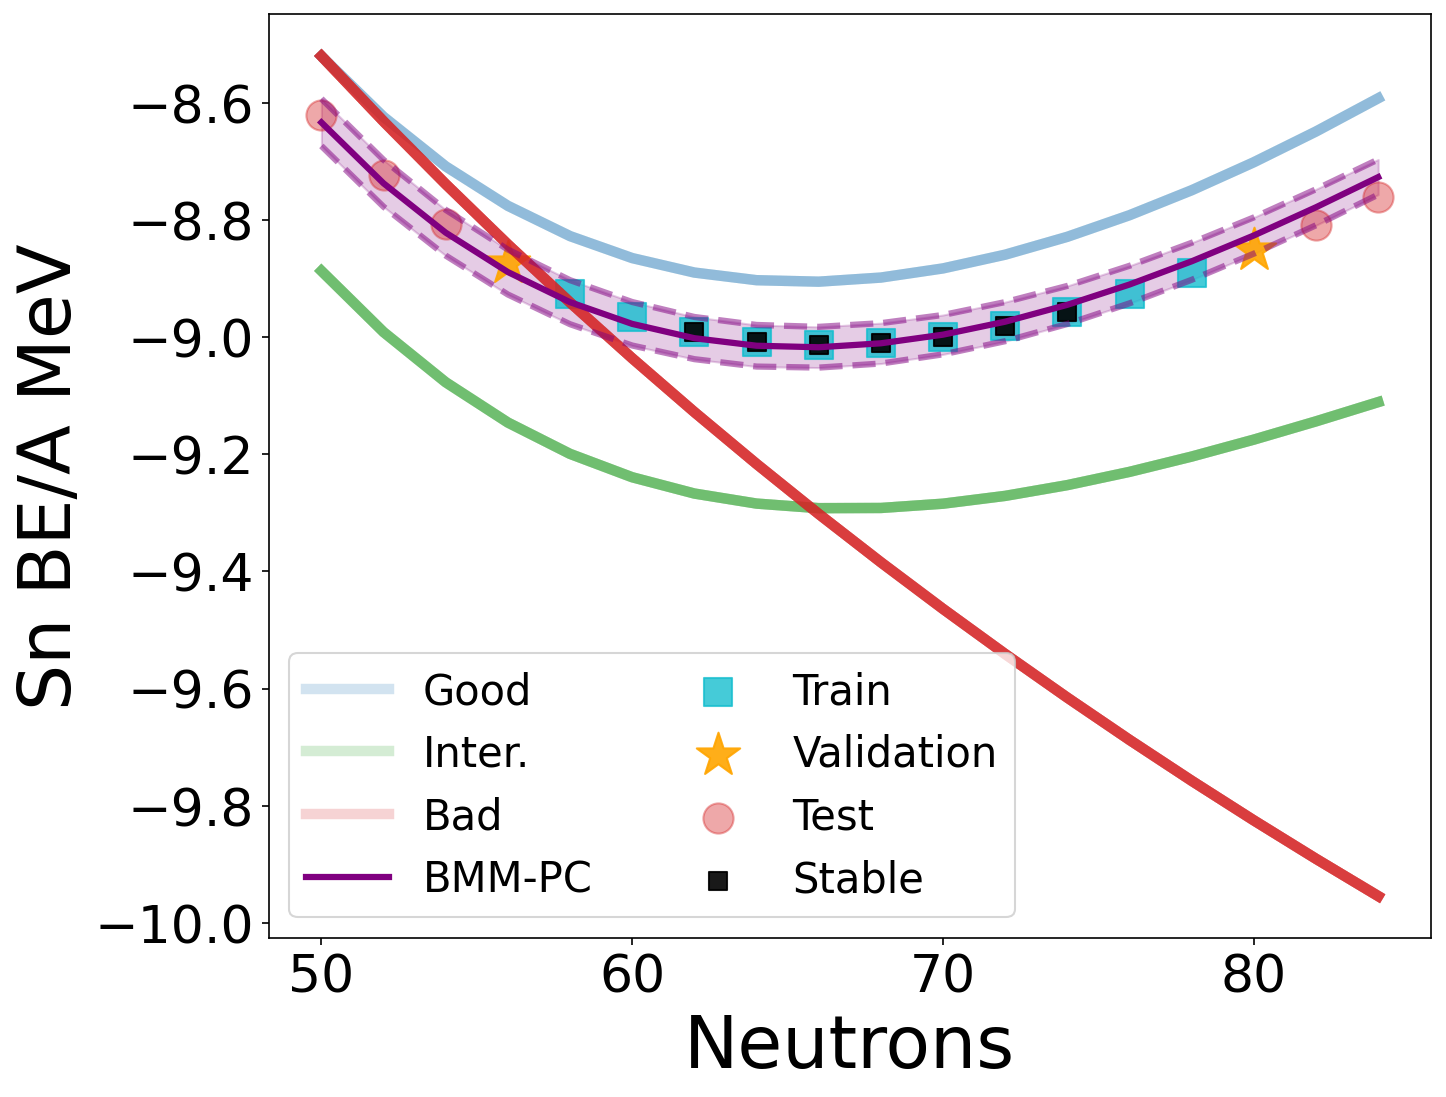

In [339]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(10,8), dpi=150)


alpha_models=0.2

model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]]/filtered_models_output["A"], label = n_Labels[class_index], color=colors[class_index],alpha = alpha_models,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]]/filtered_models_output["A"], color=colors[class_index],alpha = alpha_models,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0



#Select what to plot, either the super model or the naive version
####################################################################################
name="BMM-PC"
samples_plot=np.copy(rndm_m)

# name="BMM-PC-Constraint"
# samples_plot=np.copy(rndm_m_MCMC)

# name="BMM-0"
# samples_plot=np.copy(rndm_m_naive)
####################################################################################


mean = np.mean(samples_plot,axis=0)/filtered_models_output["A"]
upper = (np.percentile(samples_plot, 97.5, axis=0))/filtered_models_output["A"]

lower = (np.percentile(samples_plot, 2.5, axis=0))/filtered_models_output["A"]

plt.plot(filtered_models_output["N"], mean, color="purple", label=name,linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2)




size_multiplyier=6

ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth']/filtered_models_output_train["A"], label = "Train",  alpha = alpha_trainig,color=color_trainig,s=size_trainig*size_multiplyier,marker=marker_trainig)

ax.scatter(x = filtered_models_output_validation["N"], y = filtered_models_output_validation['truth']/filtered_models_output_validation["A"], label = "Validation", alpha=alpha_validation ,color=color_validation,s=size_validation*size_multiplyier,marker=marker_validation)

ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth']/filtered_models_output_test["A"], label = "Test", alpha = alpha_testing,color=color_testing,s=size_testing*size_multiplyier,marker=marker_testing)

ax.scatter(x = filtered_models_output_stable["N"], y = filtered_models_output_stable['truth']/filtered_models_output_stable["A"], label = "Stable", alpha = 0.9,color='k',s=80,marker="s")





plt.xlabel("Neutrons",fontsize=35)
plt.ylabel(Selected_element_name+ " BE/A MeV",fontsize=35)
plt.legend(fontsize=20,markerscale=1,ncol=2 )

plt.show()

### Computing the root mean squared errors for the BMM PC

In [340]:
super_model_resituals_train=supermodel_train  -  models_output_train['truth'].tolist()
super_model_residuals_validation= supermodel_validation-models_output_validation['truth'].tolist()
super_model_residuals_test = supermodel_test-models_output_test['truth'].tolist()

sigma_train=np.sqrt(np.sum(super_model_resituals_train**2) / len(super_model_resituals_train) )
sigma_validation=np.sqrt(np.sum(super_model_residuals_validation**2) / len(super_model_residuals_validation) )
sigma_test=np.sqrt(np.sum(super_model_residuals_test**2) / len(super_model_residuals_test) )





### Computing the root mean squared errors for the BMM Naive (all models)

In [341]:

naive_model_resituals_train=supermodel_train_naive-models_output_train['truth'].tolist()
naive_model_residuals_validation= supermodel_validation_naive-models_output_validation['truth'].tolist()
naive_model_residuals_test = supermodel_test_naive-models_output_test['truth'].tolist()



sigma_naive_train=np.sqrt(np.sum(naive_model_resituals_train**2) / len(naive_model_resituals_train) )
sigma_naive_validation=np.sqrt(np.sum(naive_model_residuals_validation**2) / len(naive_model_residuals_validation) )
sigma_naive_test=np.sqrt(np.sum(naive_model_residuals_test**2) / len(naive_model_residuals_test) )



In [342]:
[sigma_train,sigma_validation,sigma_test]

[2.0383039092045405, 2.791852309690265, 4.636880993390015]

In [343]:
[sigma_naive_train,sigma_naive_validation,sigma_naive_test]

[1.5122610095151974, 2.3981097150425166, 5.2693212486457135]

In [ ]:
model_summary[ 'rmse_test'][4+5:]

array([], dtype=float64)

In [213]:
np.mean(model_summary[ 'rmse_train'][4+5:])

/home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [214]:
np.mean(model_summary[ 'rmse_validation'][4+5:])

nan

In [215]:
np.mean(model_summary[ 'rmse_test'][4+5:])

nan

### Lets plot them in a graphical way to make it easier to understand

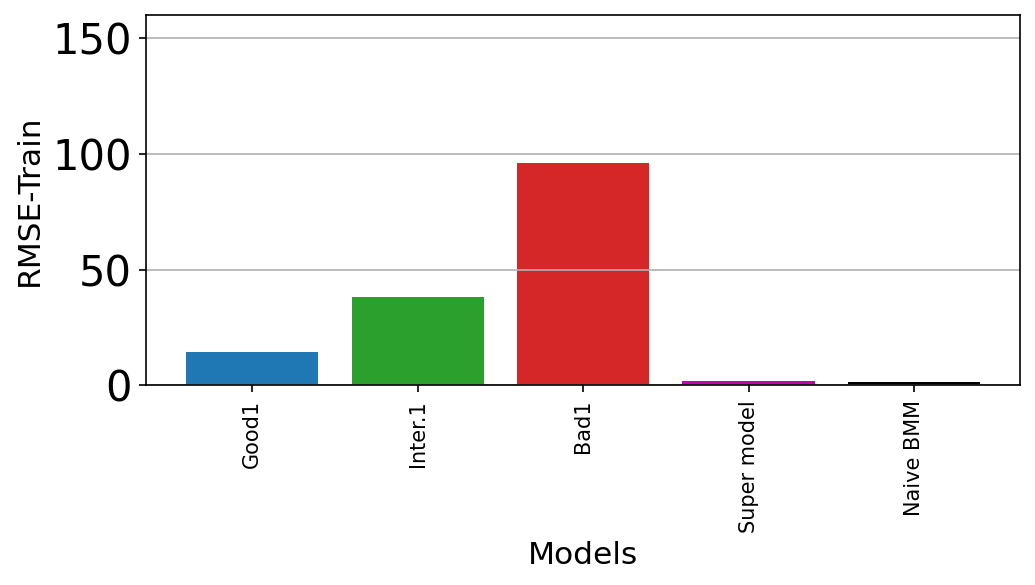

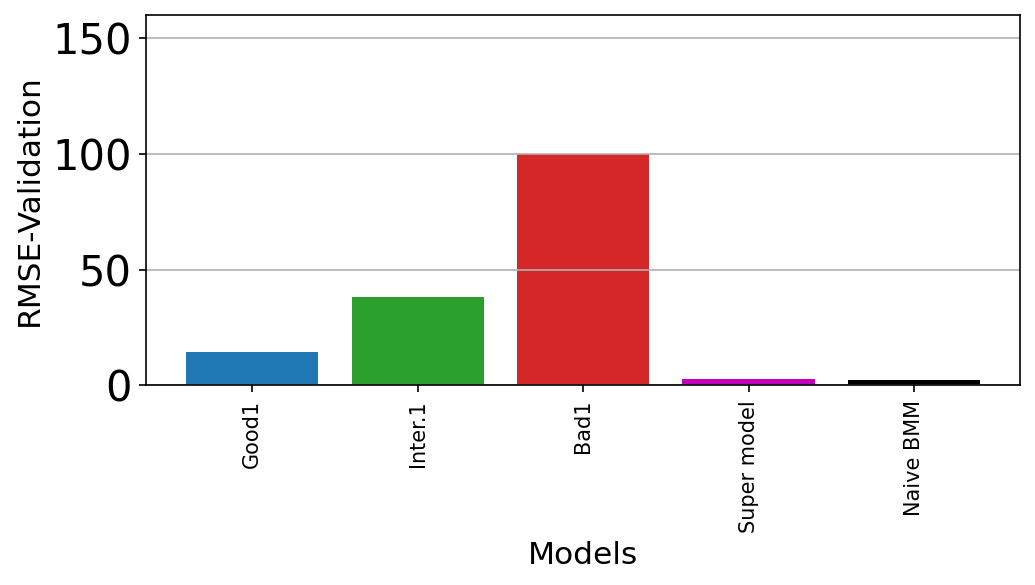

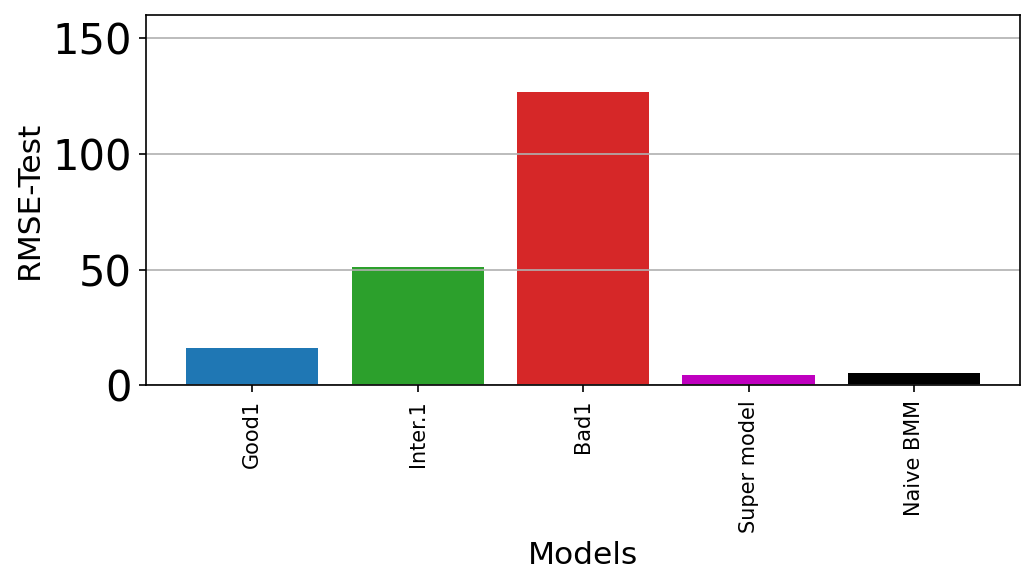

In [216]:
#Overall max height for the plots
y_max=160

plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)


################################

# Training round

labels=list(models_output.keys())
plt.figure(figsize=(7, 4),dpi=150)


rmse_train=[]


model_index=0
class_index=0
for n_vals in n_classes:
    rmse_av=0
    for i in range(n_vals):
        
        # ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], 
        #         label = n_Labels[class_index], color=colors[class_index],alpha = alpha_models,linewidth=5)
        plt.bar(n_Labels[class_index] + str(i+1) , model_summary["rmse_train"][model_index], color=colors[class_index])
        rmse_av=rmse_av+model_summary["rmse_train"][model_index]
        model_index=model_index+1
    if n_vals!=0:
        rmse_train.append(rmse_av/n_vals)
    class_index=class_index+1


plt.bar('Super model' , sigma_train, color='m')
plt.bar('Naive BMM' , sigma_naive_train, color='k')

plt.xlabel('Models',fontsize=15)
plt.ylabel('RMSE-Train',fontsize=15)
plt.ylim(0,y_max)
plt.xticks(fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

################################

# Validation round

labels=list(models_output.keys())
plt.figure(figsize=(7, 4),dpi=150)
# plt.figure(dpi=150)

rmse_validation=[]


model_index=0
class_index=0
for n_vals in n_classes:
    rmse_av=0
    for i in range(n_vals):
        
        plt.bar(n_Labels[class_index] + str(i+1) , model_summary["rmse_validation"][model_index], color=colors[class_index])
        rmse_av=rmse_av+model_summary["rmse_validation"][model_index]
        model_index=model_index+1
    if n_vals!=0:
        rmse_validation.append(rmse_av/n_vals)
    class_index=class_index+1


plt.bar('Super model' , sigma_validation, color='m')

plt.bar('Naive BMM' , sigma_naive_validation, color='k')

plt.xlabel('Models',fontsize=15)
plt.ylabel('RMSE-Validation',fontsize=15)
plt.ylim(0,y_max)
plt.xticks(fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

################################

# Testing round

labels=list(models_output.keys())
plt.figure(figsize=(7, 4),dpi=150)
# plt.figure(dpi=150)

rmse_test=[]


model_index=0
class_index=0
for n_vals in n_classes:
    rmse_av=0
    for i in range(n_vals):
        
        plt.bar(n_Labels[class_index] + str(i+1) , model_summary["rmse_test"][model_index], color=colors[class_index])
        rmse_av=rmse_av+model_summary["rmse_test"][model_index]
        model_index=model_index+1
    if n_vals!=0:
        rmse_test.append(rmse_av/n_vals)
    class_index=class_index+1


plt.bar('Super model' , sigma_test, color='m')
plt.bar('Naive BMM' , sigma_naive_test, color='k')

plt.xlabel('Models',fontsize=15)
plt.ylabel('RMSE-Test',fontsize=15)
plt.ylim(0,y_max)
plt.xticks(fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

################################

# Everything round

## How results change as we change the number of PCs

In [217]:
def PC_RMSE_calculator(components_kept):  #A function that will basically run everything above (without the plots) with varying number of kept PCs




    S_hat=np.array([S[i] for i in range(components_kept)])

    # U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)])
    U_hat=np.array([U.T[i]*np.linalg.norm(predictions_train_mean) for i in range(components_kept)])

    # Vt_hat=np.array([Vt[i] for i in range(components_kept)])
    Vt_hat=np.array([Vt[i]/S_hat[i]*np.linalg.norm(predictions_train_mean) for i in range(components_kept)])   


    if centering_data:
        num_components=components_kept+1
    else:
        num_components=components_kept



    #########################################
    #Creating principal components that are for training. These should be equivalent to \hat U, and if they are not there is something wrong
    models_PC_train = {}
    if centering_data:
        models_PC_train[str("PC_0")] = predictions_train_mean       
    for i in range(components_kept):
        models_PC_train[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_train.T)
    models_PC_train["N"] = models_output_train["N"]
    models_PC_train["Z"] = models_output_train["Z"]
    models_PC_train["A"] = models_PC_train["N"] + models_PC_train["Z"]
    models_PC_training = pd.DataFrame(models_PC_train)
    #########################################

    #########################################
    #Creating principal components that are for validation
    models_PC_validation = {}
    if centering_data:
        models_PC_validation[str("PC_0")] = predictions_validation_mean
    for i in range(components_kept):
        models_PC_validation[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_validation.T)
    models_PC_validation["N"] = models_output_validation["N"]
    models_PC_validation["Z"] = models_output_validation["Z"]
    models_PC_validation["A"] = models_PC_validation["N"] + models_PC_validation["Z"]
    models_PC_validation = pd.DataFrame(models_PC_validation)
    #########################################

    #########################################
    #Creating principal components that are for testing
    models_PC_testing = {}
    if centering_data:
        models_PC_testing[str("PC_0")] = predictions_test_mean
    for i in range(components_kept):
        # models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)*S_hat[i]
        models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)

    models_PC_testing["N"] = models_output_test["N"]
    models_PC_testing["Z"] = models_output_test["Z"]
    models_PC_testing["A"] = models_PC_testing["N"] + models_PC_testing["Z"]
    models_PC_testing = pd.DataFrame(models_PC_testing)
    #########################################

    #Creating principal components that are valid everywhere (testing + training + validation)
    models_PC = {}
    if centering_data:
        models_PC[str("PC_0")] = predictions_mean
    for i in range(components_kept):
        models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)
    models_PC = pd.DataFrame(models_PC)
    models_PC["N"] = Full_set.T[0]
    models_PC["Z"] = Full_set.T[1]
    models_PC["A"] = models_PC["N"] + models_PC["Z"]
    #########################################

    key_list_PCs=list(models_PC_testing.keys())


    X=np.copy(U_hat)
    if centering_data:
        y=np.copy(models_output_train["truth"].tolist())-predictions_train_mean
    else:
        y=np.copy(models_output_train["truth"].tolist())
    #Making the list of principal components across the train part. These should be identical to the X on top made by \hat U
    X_train=[]
    for i in range(num_components):
        X_train.append(models_PC_train[key_list_PCs[i]].tolist())
    X_train=np.array(X_train)
    #Making the list of principal components across the validation part
    X_validation=[]
    for i in range(num_components):
        X_validation.append(models_PC_validation[key_list_PCs[i]].tolist())
    X_validation=np.array(X_validation)

    #Making the list of principal components across the testing part
    X_test=[]
    for i in range(num_components):
        X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
    X_test=np.array(X_test)
    #Making the list of principal components across the entire chart (training+validation+testing)
    X_full=[]
    for i in range(num_components):
        X_full.append(models_PC[key_list_PCs[i]].tolist())
    X_full=np.array(X_full)

    

    # 1) Find the least square solution for the training part
    X_T_X_inv = np.linalg.inv(X.dot(X.T))
    beta = X_T_X_inv.dot(X).dot(y)
    
    #1.5) Construct the super model across the entire range and the test range
    if centering_data:
        beta_full= np.insert(beta, 0, 1)  #Augmenting the beta list to add a "1" at the begining so it can use the PC0 (the mean)
    else:
        beta_full=np.copy(beta)

    # supermodel=X.T.dot(beta_full)
    supermodel=X_train.T.dot(beta_full)
    supermodel_train=np.copy(supermodel)
    supermodel_validation=X_validation.T.dot(beta_full)
    supermodel_test=X_test.T.dot(beta_full)
    supermodel_full=X_full.T.dot(beta_full)

    
    super_model_resituals_train=supermodel_train-models_output_train['truth'].tolist()
    super_model_residuals_validation= supermodel_validation-models_output_validation['truth'].tolist()
    super_model_residuals_test = supermodel_test-models_output_test['truth'].tolist()
    super_model_residuals_full = supermodel_full-models_output['truth'].tolist()

    sigma_train=np.sqrt(np.sum(super_model_resituals_train**2) / len(super_model_resituals_train) )
    sigma_validation=np.sqrt(np.sum(super_model_residuals_validation**2) / len(super_model_residuals_validation) )
    sigma_test=np.sqrt(np.sum(super_model_residuals_test**2) / len(super_model_residuals_test) )
    sigma_full=np.sqrt(np.sum(super_model_residuals_full**2) / len(super_model_residuals_full) )


    return [sigma_train,sigma_validation,sigma_test,sigma_full]

In [81]:
if centering_data:
    s_validation=[np.linalg.norm(np.array(models_output_validation["truth"].tolist())-predictions_validation_mean)/np.sqrt(len(predictions_validation_mean))]
    s_test=[np.linalg.norm(np.array(models_output_test["truth"].tolist())-predictions_test_mean)/np.sqrt(len(predictions_test_mean))]
    s_train=[np.linalg.norm(np.array(models_output_train["truth"].tolist())-predictions_train_mean)/np.sqrt(len(predictions_train_mean))]
    s_all=[np.linalg.norm(np.array(models_output["truth"].tolist())-predictions_mean)/np.sqrt(len(predictions_mean))]
    
else:
    s_test=[]
    s_train=[]
    s_validation=[]
    s_all=[]

if centering_data:
    for i in range(1,len(S)):
        res=PC_RMSE_calculator(i)
        s_train.append(res[0])
        s_validation.append(res[1])
        s_test.append(res[2])
        
        s_all.append(res[3])
else:
    for i in range(1,len(S)+1):
        res=PC_RMSE_calculator(i)
        s_train.append(res[0])
        s_validation.append(res[1])
        s_test.append(res[2])
        
        s_all.append(res[3])

In [82]:
# if centering_data:
#     s_validation=[np.linalg.norm(np.array(models_output_validation["truth"].tolist())-predictions_validation_mean)/np.sqrt(len(predictions_validation_mean))]
#     s_test=[np.linalg.norm(np.array(models_output_test["truth"].tolist())-predictions_test_mean)/np.sqrt(len(predictions_test_mean))]
#     s_train=[np.linalg.norm(np.array(models_output_train["truth"].tolist())-predictions_train_mean)/np.sqrt(len(predictions_train_mean))]
#     s_all=[np.linalg.norm(np.array(models_output["truth"].tolist())-predictions_mean)/np.sqrt(len(predictions_mean))]
    
# else:
#     s_test=[]
#     s_train=[]
#     s_validation=[]
#     s_all=[]

# for i in range(1,len(S)):
#     res=PC_RMSE_calculator(i)
#     s_train.append(res[0])
#     s_validation.append(res[1])
#     s_test.append(res[2])
    
#     s_all.append(res[3])

### Plotting the results

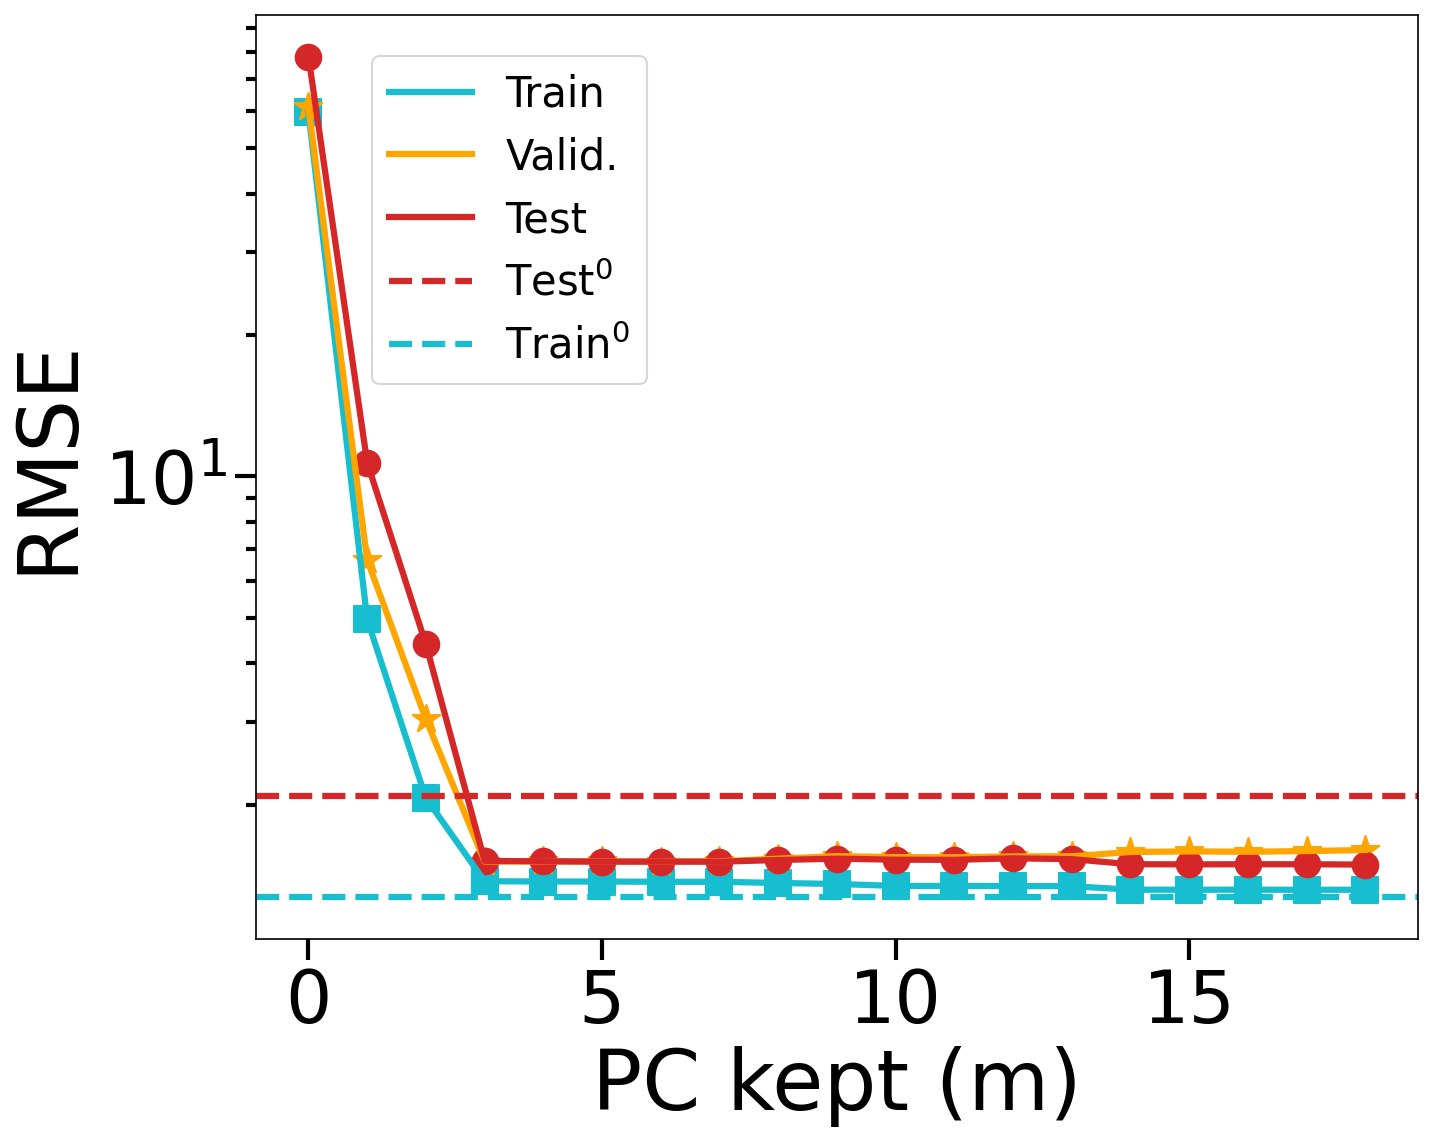

In [83]:
plt.rc("xtick", labelsize=35)
plt.rc("ytick", labelsize=35)

fig, ax = plt.subplots(figsize=(10,8),dpi=150)
fig.patch.set_facecolor('white')


# color_trainig=colors[9]
# color_validation='orange'
# color_testing=colors[3]

# marker_trainig='s'
# marker_validation='*'
# marker_testing='o'



# size_trainig=30
# size_validation=80
# size_testing=35

# alpha_trainig=0.8
# alpha_validation=0.9
# alpha_testing=0.4



size_points=150


ax.scatter(np.arange(0,len(s_train)), s_train,color=color_trainig,s=size_points,marker=marker_trainig)
ax.plot(np.arange(0,len(s_train)), s_train,color=color_trainig,linewidth=3,label="Train")

ax.scatter(np.arange(0,len(s_validation)), s_validation,color=color_validation,s=size_points*1.3,marker=marker_validation)
ax.plot(np.arange(0,len(s_validation)), s_validation,color=color_validation,linewidth=3,label="Valid.")


ax.scatter(np.arange(0,len(s_test)), s_test,color=color_testing,s=size_points,marker=marker_testing)
ax.plot(np.arange(0,len(s_test)), s_test,color=color_testing,linewidth=3,label="Test")

# ax.scatter(np.arange(1,len(s_all)+1), s_all,color='k',s=90,marker="s")
# ax.plot(np.arange(1,len(s_all)+1), s_all,color='k',linewidth=3,label="All",linestyle='dashed')

ax.axhline(y=sigma_naive_test,color=color_testing,label="Test$^0$",linestyle='dashed',linewidth=3)

ax.axhline(y=sigma_naive_train,color=color_trainig,label=f"Train$^0$",linestyle='dashed',linewidth=3)


ax.set_yscale('log')
ax.set_xlabel(r'PC kept (m)',fontsize=40)
ax.set_ylabel(r' RMSE',fontsize=40);
ax.set_xticks([0,5,10,15])
# ax.set_yticks()
# plt.ylim(1.7*10**(-2),1)

# plt.title("Singular values decay",fontsize=30)

plt.tick_params(axis='both',       
            which='major',      
            length=10,        
            width=2)

plt.tick_params(axis='both',       
            which='minor',      
            length=5,        
            width=2) 

# plt.annotate(f'$5 x 10^{{-1}}$', xy=(-0.12,1), xycoords='axes fraction',
#              ha='center', va='top', fontsize=30) 

# plt.annotate(f'$2 x 10^{{-2}}$', xy=(-0.12,0.1), xycoords='axes fraction',
#              ha='center', va='top', fontsize=30) 



plt.legend(fontsize=20,loc=(0.1,0.6))
plt.show()

## Constrained approach (simplex, MCMC)

Below are the lines of codes to do the MCMC approach with the simplex constraint. We are not running that for now. 

In [84]:
print(1/0)
#To stop notebook from running if we hit the run all command

ZeroDivisionError: division by zero

In [ ]:

#Interestingly enough, if we are centering the data, the constraint that the sum of the weights is 0 is automatically enforced. They can still be negative though

if centering_data:  #Calculating a bias term to add to the coefficient transformation to account for the \phi0 term
    bias0=np.full(len(model_predictions_train.T),1/len(model_predictions_train.T))
else:
    bias0=np.full(len(model_predictions_train.T),0)

def b1_finder(beta_2m,Vt_hat):
#     beta_2m is a list of the beta values that are active
    if len(beta_2m)<1:
        print("AAAAAAAAAAA!")
    return (1-np.sum(bias0)-np.sum(np.dot(Vt_hat[1:].T,beta_2m)))/np.sum(Vt_hat[0])
    # return (1-np.sum(bias0)-np.sum(np.dot(Vt_hat[1:].T,beta_2m)))/np.sum(Vt_hat.T[0])


if centering_data:  #If we center the data we need to remove the PC that has to do with the center \phi0
    X_train_MCMC=np.copy(X_train[1:])
else:
    X_train_MCMC=np.copy(X_train)



# Define the likelihood function for given errors sigma
# We might want to re-define it so it takes the data as an input
def log_likelihood_PC(beta_2m,data):
    #Assumed format for data=[yvals], it is also assummed to be centered or not centered directly (either y-\phi0 or just y)
    
    if centering_data:  #When centering the data "beta_2m" actually contains the full betas
        residuals=data-(X_train_MCMC.T.dot(beta_2m))
    else: #If the data is not centered, we need to respect the constraint and the first b adjust appropiatly
        beta = np.insert(beta_2m, 0, b1_finder(beta_2m,Vt_hat))
        residuals=data-(X_train_MCMC.T.dot(beta))



    

    return -np.sum(residuals**2)


# Define the prior function
def log_prior_PC(beta_2m,Vt_hat):


    if centering_data:
        omegas=np.dot(beta_2m,Vt_hat) + bias0
    else:
        beta = np.insert(beta_2m, 0, b1_finder(beta_2m,Vt_hat))
        
        omegas=np.dot(beta,Vt_hat) + bias0
    
    
    if  np.any(omegas < 0):
        return -np.infty
    else:
        return 0
    
# Define the prior function, this is just so we can see if we recover the same posterior as compared to the case where no constraint is present
#Not sure why I called "unormalized" though...
def log_prior_PC_unormalized(beta,Vt_hat):
#     beta = np.insert(beta_2m, 0, b1_finder(beta_2m,Vt_hat))
    
    # omegas=np.dot(beta,Vt_hat) + bias0
    
    return 0
    
    if  np.any(omegas < 0):
        return -np.infty
    else:
        return 0
        
# Define the Metropolis algorithm
def metropolis(data,sigma, log_prior,log_likelihood,\
               num_iterations, step_size,initial_parameters,Vt_hat,burn_samples=10000):
#     step_size should be a list the size of the parameters of the model


    if centering_data:
        if len(initial_parameters)!=len(X_train_MCMC):
            print("Error, need to pass all parameters because you are centering the data, not just [b2,b3....]")
            return 

    #thermalizing

    # Set the initial state of the chain
    params_current=initial_parameters
    params_list=[]
    posterior_list=[]
    
    acceptance_times=0
    
    cov_step_size=np.diag(step_size)**2
    

    
    log_posterior_current=(log_likelihood(params_current,data))/sigma**2 + (log_prior(params_current,Vt_hat))

    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)

        log_posterior_proposed=(log_likelihood(params_proposed,data))/sigma**2 + (log_prior(params_proposed,Vt_hat))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, np.exp((+log_posterior_proposed - log_posterior_current)))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            log_posterior_current=log_posterior_proposed


    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
   
        log_posterior_proposed=(log_likelihood(params_proposed,data))/sigma**2+ (log_prior(params_proposed,Vt_hat))

        # Calculate the acceptance probability
        acceptance_prob = min(1, np.exp((+log_posterior_proposed - log_posterior_current)))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            log_posterior_current=log_posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        if centering_data:
            params_list.append(params_current)
        else:
            params_list.append(np.insert(params_current, 0, b1_finder(params_current,Vt_hat)))
            
        posterior_list.append(log_posterior_current*sigma**2)
        
    
    #Rule of thumb acceptance is around 30%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print(acceptance_times/num_iterations*100,"%")
    
    return(np.array(params_list),np.array(posterior_list),\
           acceptance_times/num_iterations*100)

### For the MCMC part, the step sizes depend a lot on which scenario we are, so we made a couple of explorations for different scenarios.

### Since we don't know the model error (sigma) a priori, we are guessing it and then re-starting the chain with that new guess. A full Bayesian approach where sigma is estimated alongside the coefficient would be nice

In [ ]:
# %%time

# #For the case of 1, 1, 1 models keeping 3 PC
# if computing_MCMC:
    # met_res=metropolis(y,0.05, log_prior_PC,log_likelihood_PC,\
    #                100000, np.array([0.004,0.004]),np.array([0.0,0.0]),Vt_hat,normalized=True)

In [ ]:
%%time

#For the case of 3, 5, 10 models keeping 3 PC
if computing_MCMC:
    met_res=metropolis(y,0.05, log_prior_PC,log_likelihood_PC,\
                50000, np.array([0.0045,0.0004,0.000035]),np.array([-5.8,0.8,0.0073]),Vt_hat,burn_samples=20000)

In [ ]:
labelsChains = [f'$b_{i}$' for i in range(1, len(beta) + 1)]

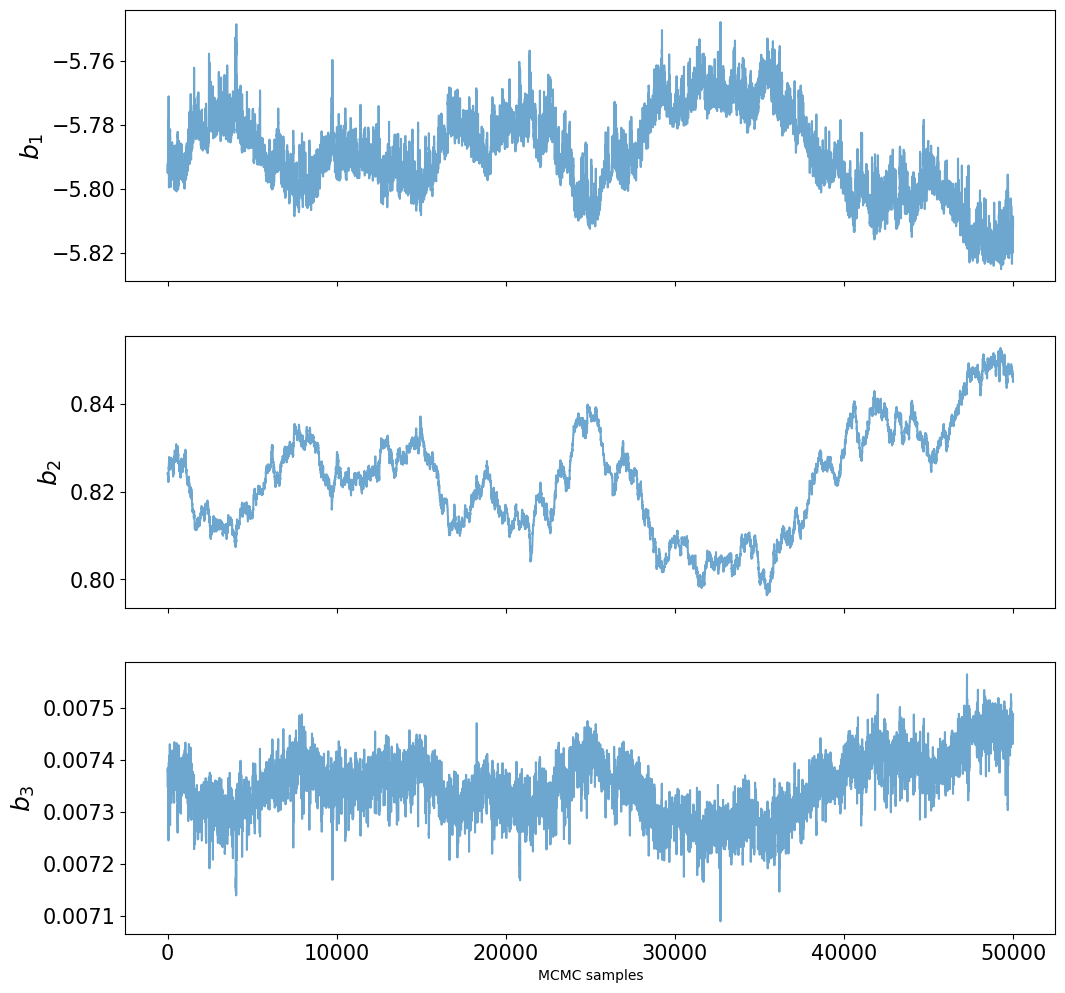

In [ ]:


nparams=len(labelsChains)

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
fig, axs = plt.subplots(nparams, 1, figsize=(12, 12), sharex='all')

for i in range(nparams):

    axs[i].plot(met_res[0].T[i], alpha=0.65)
    axs[i].set_ylabel(labelsChains[i], fontsize=18)

plt.xlabel('MCMC samples')
plt.show()


In [ ]:
#Calculating the empirical sigma

if computing_MCMC:
    emp_sigma=np.sqrt(-np.mean(met_res[1])/len(y))

In [ ]:
if computing_MCMC:
    print(emp_sigma)

0.04922384459701324


In [ ]:
emp_sigma

0.04922384459701324

### We now run it again with the new empirical sigma

In [ ]:
%%time
if computing_MCMC:
    met_res=metropolis(y,emp_sigma, log_prior_PC,log_likelihood_PC,\
                150000, np.array([0.0045,0.0004,0.000035]),np.array([-5.8,0.8,0.0073]),Vt_hat,burn_samples=40000)

/tmp/ipykernel_1224/814576804.py:106: RuntimeWarning: invalid value encountered in scalar subtract
  acceptance_prob = min(1, np.exp((+log_posterior_proposed - log_posterior_current)))


27.415333333333336 %
CPU times: user 22.8 s, sys: 93.5 ms, total: 22.9 s
Wall time: 23.6 s


In [ ]:
if computing_MCMC:
    np.sqrt(-np.mean(met_res[1])/len(y))/emp_sigma

### The last cell compares the old empirical sigma with the new, letting us know we basically nail it and can continue

In [ ]:
if computing_MCMC:
    emp_sigma=np.sqrt(-np.mean(met_res[1])/len(y))

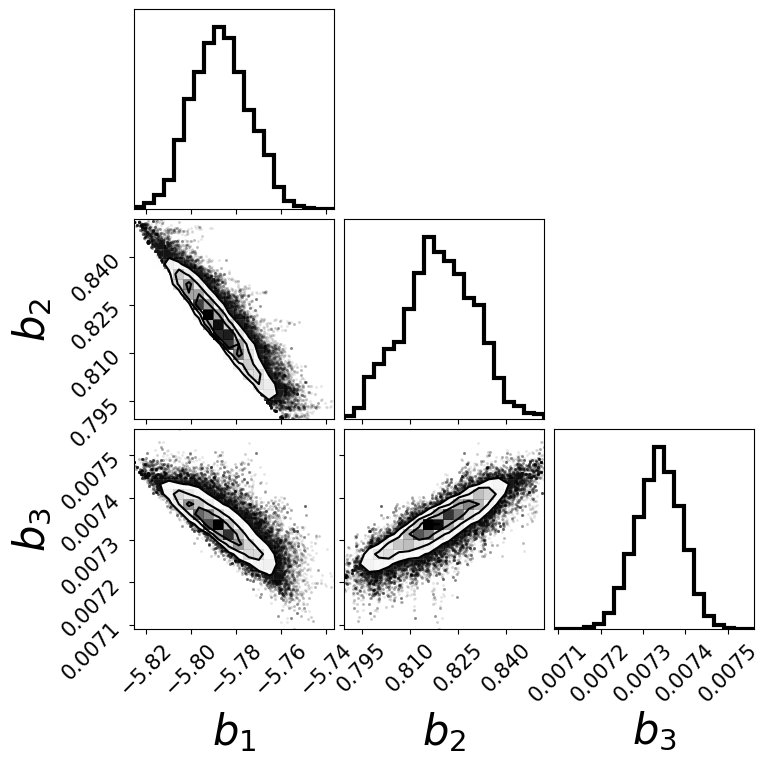

In [ ]:
#We now make a posterior distribution in the constrained space of the bs
if computing_MCMC:
    plt.rc("xtick", labelsize=15)
    plt.rc("ytick", labelsize=15)

    figure = corner.corner(met_res[0],bins=20, dpi=300, hist_kwargs={"linewidth": 3},
                        labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)],
    #                        truths=beta,truth_color="r",
                        label_kwargs={"fontsize": 30},labelpad=0.1)


    plt.show()

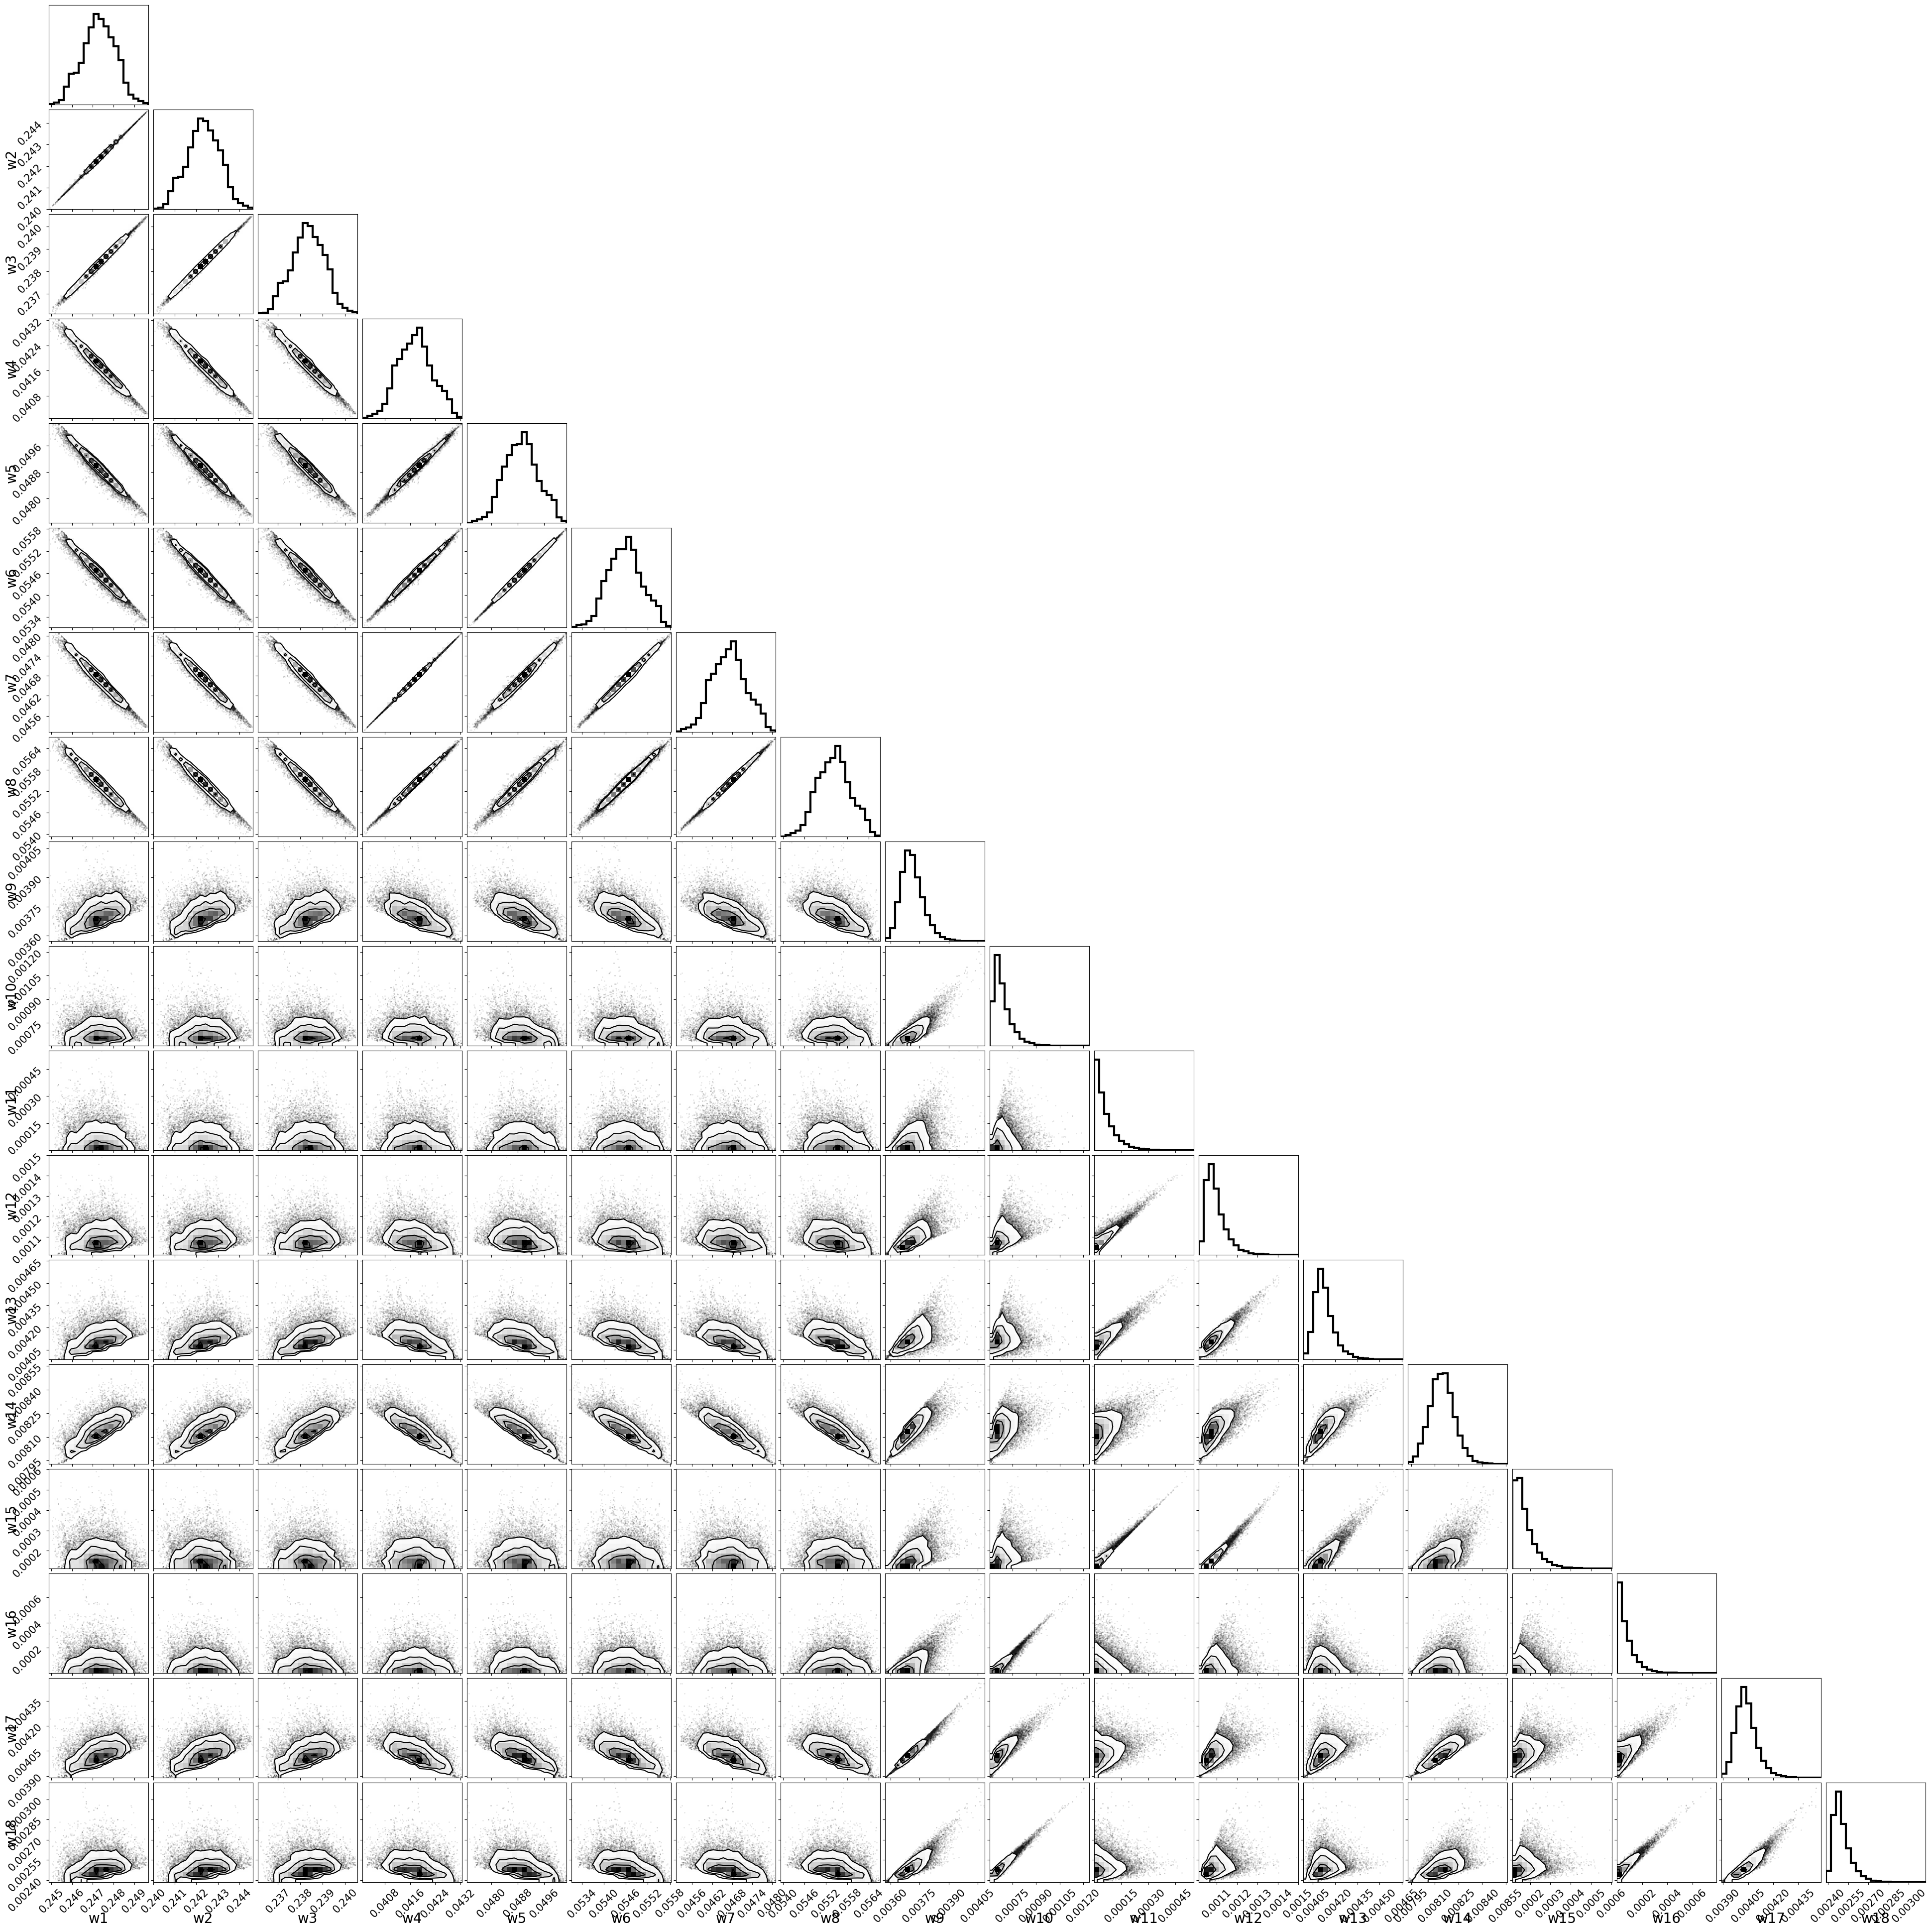

In [ ]:
sampled_numbers=20000

rng = np.random.default_rng()
theta_rand = rng.choice(met_res[0], sampled_numbers, replace=False)

if computing_MCMC:
    if centering_data:
        samples_naive_space = np.array([np.dot(betaval,Vt_hat) + np.full(len(Vt_hat.T),1/len(Vt_hat.T)) for  betaval in theta_rand])
        figure = corner.corner(samples_naive_space, bins=20, hist_kwargs={"linewidth": 3},labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)],label_kwargs={"fontsize": 20})
    else:
        samples_naive_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in theta_rand])
        figure = corner.corner(samples_naive_space, bins=20, dpi=300, hist_kwargs={"linewidth": 3},labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)],label_kwargs={"fontsize": 30})

    plt.show()

In [ ]:
if computing_MCMC:
    #Checking that indeed we respect the constraint
    print([np.sum(samples_naive_space[i]) for i in range(20)])

[0.9999999999999972, 0.9999999999999973, 0.9999999999999973, 0.9999999999999973, 0.9999999999999972, 0.9999999999999972, 0.9999999999999973, 0.9999999999999972, 0.9999999999999971, 0.9999999999999971, 0.9999999999999972, 0.9999999999999972, 0.9999999999999972, 0.9999999999999973, 0.9999999999999973, 0.9999999999999974, 0.9999999999999973, 0.9999999999999973, 0.9999999999999972, 0.9999999999999972]


### Checking now that if we were to run the MCMC approach without the constraint we will recover what we expect from the direct sampling we used before

In [ ]:
if computing_MCMC:
    met_res_unnorm=metropolis(y,0.5, log_prior_PC_unormalized,log_likelihood_PC,\
               50000, np.array([1,0.1,0.1]),np.array([150,0.0,0.0]),Vt_hat)

/tmp/ipykernel_1224/814576804.py:106: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1, np.exp((+log_posterior_proposed - log_posterior_current)))


37.419999999999995 %


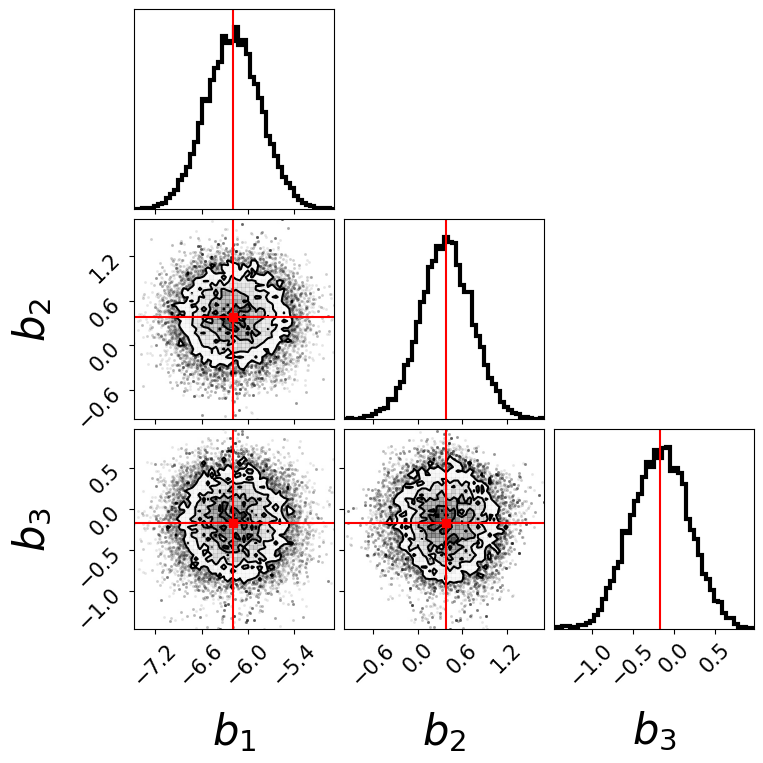

In [ ]:
if computing_MCMC:
    plt.rc("xtick", labelsize=15)
    plt.rc("ytick", labelsize=15)

    figure = corner.corner(met_res_unnorm[0],bins=50, dpi=300, hist_kwargs={"linewidth": 3},
                        labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)], truths=beta,truth_color="r",
                        label_kwargs={"fontsize": 30},labelpad=0.1)


    plt.show()